<div style="font-size: 30px; font-weight: bold; line-height: 1.2; margin-top: 20px; margin-bottom: 20px;">Hierarchical Forecasting of ATM Withdrawals</div>

<div style="font-size: 20px; font-weight: bold; line-height: 1.2; margin-top: 20px; margin-bottom: 20px;">Comparison of local and global models for hierarchical time series forecasting of ATM withdrawals.</div>

# Word of introduction

## Project purpose

Banking relies on extensive networks of **ATMs spread across different locations**, each with its own unique withdrawal patterns. These patterns create individual time series for every ATM, which, when combined, naturally form a **hierarchical structure** — city, region, country, and so on. This structure makes it possible to analyze and forecast ATM withdrawals not just for a single ATM machine but for broader areas too.

The project focuses on two forecasting approaches: **local models**, which analyze each ATM’s data separately to capture its specific trends, and **global models**, which analyze all data collectively to uncover patterns and relationships across the entire network.

Real-world data on daily ATM withdrawals from various regions in Switzerland is used for analysis. Additionally, **reconciliation techniques** were applied to maintain consistency in forecasts across all levels of the hierarchy, highlighting the strengths of these approaches and their potential to improve hierarchical time series forecasting

## Hierarchical time series forecasting

### Hierarchical time series

**Hierarchical time series** are data organized in a **hierarchical structure**, where there are several levels at which time series from lower levels are aggregated to series at higher levels. The hierarchy typically reflects a natural structure, such as geographical locations (e.g., city, region, country), product categories (e.g., individual items, categories, total sales), or organizational structures (e.g., individual departments, divisions, company-wide metrics).

Based on the below chart, the hierarchical time series can be illustrated with a simple example - sales data for a company organized at different levels:
- *TOTAL* - the total sales of the company. It consists of two main departments: *A* and *B*.
    - Department *A* - includes sales in three product categories: *a1*, *a2*, and *a3*.
        - *a1*, *a2*, and *a3* are specific product subcategories within Department *A*.

    - Department *B* - includes sales in two product categories: *b1* and *b2*.
        - *b1* and *b2* are specific product subcategories within Department *B*.

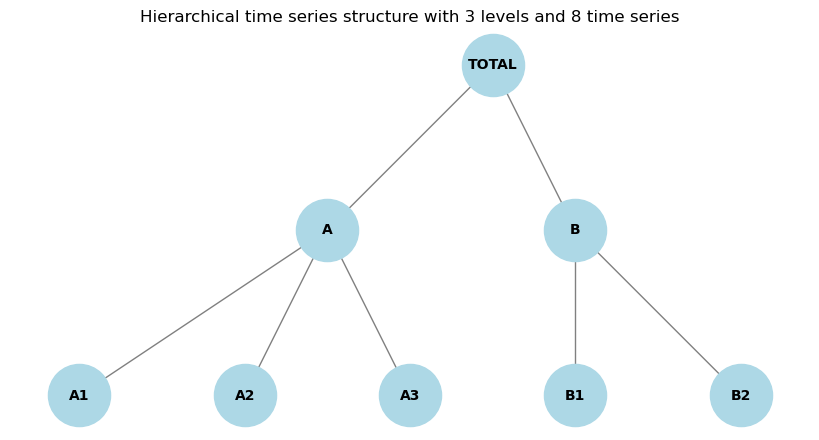

In [1]:
import matplotlib.pyplot as plt
import networkx as nx

G = nx.DiGraph()

# Define the hierarchical structure
edges = [
    ("TOTAL", "A"),
    ("TOTAL", "B"),
    ("A", "A1"),
    ("A", "A2"),
    ("A", "A3"),
    ("B", "B1"),
    ("B", "B2")
]

G.add_edges_from(edges)

pos = nx.spring_layout(G)
pos = nx.nx_agraph.graphviz_layout(G, prog="dot")

# Plot the graph
plt.figure(figsize=(8, 4))
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightblue', 
        font_size=10, font_weight='bold', arrows=False, edge_color='gray')

# Show plot
plt.title("Hierarchical time series structure with 3 levels and 8 time series")
plt.show()

### Hierachical forecasting

**Hierarchical forecasting** is the process of **generating forecasts for time series data organized in a hierarchical structure**. The goal is to generate accurate forecasts for all levels of the hierarchy while maintaining consistency across them.

There are two main methodologies for forecasting such data:

- **Global models** involve building a single, common model that considers all time series simultaneously (i.e. the model is evaluated based on observations from all time series from all levels of the hierarchy). This makes them helpful when individual ATMs have limited or unreliable data, as the global model can still learn from the larger set of data. However, global models may miss some of the unique patterns that are specific to certain ATMs.

- **Local models**, also referred to as series-by-series forecasting, on the other hand, are built individually for each time series at each level of the hierarchy without taking into account information from other time series. Local models focus on the unique behavior of each ATM, capturing the details of its individual withdrawal patterns. These models work well when each ATM has distinct behaviors. However, they can struggle when data is limited or inconsistent, and managing multiple models for each ATM can be time-consuming and difficult to scale.

Therefore, the choice between local and global models comes down to balancing **specificity** and **generalization**.

As a result, in the case of the local approach, as many models are estimated as there are time series, while in the case of the global approach, only one model common to all series is built. 

While many classical **statistical methods** are used for local models, **machine learning methods** are most commonly used for global models.

### Reconciliation

In scenarios where forecasts are created for **different levels of hierarchy**, the ideal situation would be for the sum of forecasts at lower levels to perfectly align with the forecasts at higher levels. However, such forecasts are often **incoherent**, meaning, for example, that the sum of predicted cash withdrawals from ATMs in individual cantons may not equal the total forecasted amount for the region to which those counties belong, and it will not match the forecast for the entire country at the highest hierarchical level. Therefore, it becomes necessary to **reconcile** these forecasts to ensure consistency and logical alignment across the different levels of the hierarchy.

There are many methods for reconciling hierarchical forecasts, but some of the most common ones and the ones that will be used in this project are:

- Bottom-up
- Top-down
- Middle-out
- Minimum trace

**Bottom-up** - Forecasts are initially generated for each time series at the lowest level of the hierarchy. These forecasts are then aggregated to produce forecasts for all other series in the hierarchy.

**Top-down** - This method starts by creating initial forecasts at the highest aggregation level of the hierarchical structure. Forecasts are then disaggregated into forecasts for each sub-series using appropriate proportions, such as: average historical proportions, proportions of historical averages or forecasted proportions (propotions evaluated based on the forecasts).

**Middle-out** - The middle-out approach combines aspects of both bottom-up and top-down forecasting. A "middle" level of the hierarchy is chosen, and forecasts are generated for all series at this level. For series above the middle level, coherent forecasts are generated using the bottom-up approach, while for series below the middle level, coherent forecasts are created using the top-down approach.

**Minimum trace** - The minimum trace method is an advanced reconciliation technique that aims to minimize the total variance (or "trace") of the forecast errors across the hierarchy. This approach adjusts the initial (or "base") forecasts at all levels of the hierarchy in such a way that they become coherent (i.e., consistent across levels) while also minimizing the overall error in the reconciled forecasts.

### Mathematical Framework

**Base Forecasts** - Vector of forecasts generated by the statistical or machine learning models.

**Reconciled Forecasts** - Updated vector of base forecasts after the reconciliation step has been applied.

**Summing Matrix (S)**: Matrix representing the hierarchical structure. By multiplying a forecast vector by the summing matrix, we ensure that the resulting forecast vector remains consistent with the hierarchy.

**Reconciliation Matrix (G):** The reconciliation process ultimately involves determining the appropriate reconciliation matrix (G) to adjust the forecasts.

## About dataset

The dataset used in the study concerns daily cash withdrawals from ATMs using debit cards in Switzerland by territorial unit. 
The data was made available by Monitoring Consumption Switzerland (https://monitoringconsumption.com/), which is a private-public partnership formed by the Swiss University of St. Gallen and two major Swiss payment service providers SIX and Worldline. 
In order to preserve the confidentiality and anonymity of the data, the transaction volume data expressed in Swiss francs (CHF) undergoes a scaling process before publication.

Aggregation of ATMs is done based on the hierarchical classification of statistical regions NUTS (Nomenclature of territorial units for statistics). Thus, the dataset consists of 3 levels: 
- NUTS-1 (country), 
- NUTS-2 (region) and 
- NUTS-3 (canton).

The dataset includes daily data from January 1, 2020 to December 31, 2022. A breakdown of the regions and cantons whose data are included in the analysis is shown in the below table.

<table>
    <thead>
        <tr>
            <th style="text-align: left;">NUTS 1</th>
            <th style="text-align: left;">NUTS 2 (region)</th>
            <th style="text-align: left;">NUTS 3 (canton)</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td rowspan="60" style="text-align: left;">Switzerland</td>
            <td rowspan="3" style="text-align: left;">Lake Geneva region</td>
            <td style="text-align: left;">Vaud (VD)</td>
        </tr>
        <tr>
            <td style="text-align: left;">Valais (VS)</td>
        </tr>
        <tr>
            <td style="text-align: left;">Geneva (GE)</td>
        </tr>
        <tr>
            <td rowspan="5" style="text-align: left;">Espace Mittelland</td>
            <td style="text-align: left;">Berne (BE)</td>
        </tr>
        <tr>
            <td style="text-align: left;">Fribourg (FR)</td>
        </tr>
        <tr>
            <td style="text-align: left;">Solothurn (SO)</td>
        </tr>
        <tr>
            <td style="text-align: left;">Neuchâtel (NE)</td>
        </tr>
        <tr>
            <td style="text-align: left;">Jura (JU)</td>
        </tr>
        <tr>
            <td rowspan="3" style="text-align: left;">Northwestern Switzerland</td>
            <td style="text-align: left;">Basel-Stadt (BS)</td>
        </tr>
        <tr>
            <td style="text-align: left;">Basel-Landschaft (BL)</td>
        </tr>
        <tr>
            <td style="text-align: left;">Aargau (AG)</td>
        </tr>
        <tr>
            <td rowspan="1" style="text-align: left;">Zürich</td>
            <td style="text-align: left;">Zürich (ZH)</td>
        </tr>
        <tr>
            <td rowspan="7" style="text-align: left;">Eastern Switzerland</td>
            <td style="text-align: left;">Glarus (GL)</td>
        </tr>
        <tr>
            <td style="text-align: left;">Schaffhausen (SH)</td>
        </tr>
        <tr>
            <td style="text-align: left;">Appenzell Ausserrhoden (AR)</td>
        </tr>
        <tr>
            <td style="text-align: left;">Appenzell Innerrhoden (AI)</td>
        </tr>
        <tr>
            <td style="text-align: left;">St. Gallen (SG)</td>
        </tr>
        <tr>
            <td style="text-align: left;">Grisons (GR)</td>
        </tr>
        <tr>
            <td style="text-align: left;">Thurgau (TG)</td>
        </tr>
        <tr>
            <td rowspan="6" style="text-align: left;">Central Switzerland</td>
            <td style="text-align: left;">Lucerne (LU)</td>
        </tr>
        <tr>
            <td style="text-align: left;">Uri (UR)</td>
        </tr>
        <tr>
            <td style="text-align: left;">Schwyz (SZ)</td>
        </tr>
        <tr>
            <td style="text-align: left;">Obwalden (OW)</td>
        </tr>
        <tr>
            <td style="text-align: left;">Nidwalden (NW)</td>
        </tr>
        <tr>
            <td style="text-align: left;">Zug (ZG)</td>
        </tr>
        <tr>
            <td rowspan="1" style="text-align: left;">Ticino region</td>
            <td style="text-align: left;">Ticino (TI)</td>
        </tr>
    </tbody>
</table>


# Imports

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import random
from math import sqrt

import lightgbm as lgb
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.signal import periodogram
#from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from statsforecast import StatsForecast
from statsforecast.models import SeasonalNaive
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.evaluation import HierarchicalEvaluation
from hierarchicalforecast.methods import BottomUp, MinTrace, MiddleOut, TopDown

# Load and prepare data

In [3]:
# Load the data
data = pd.read_csv('atm_withdrawals_data.csv')
data.head()

date canton  region         y
0  2020-04-01     AG       3  3.004878
1  2020-04-01     AI       5  0.026768
2  2020-04-01     AR       5  0.296350
3  2020-04-01     BE       2  3.527105
4  2020-04-01     BL       3  1.447041


## Missing data

In [4]:
# Convert the 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'])

# Count missing data points per time series
data_spread = data.pivot(index='date', columns='canton', values='y')
print(data_spread.isna().sum())

canton
AG    0
AI    4
AR    0
BE    0
BL    0
BS    0
FR    0
GE    0
GL    0
GR    0
JU    0
LU    0
NE    0
NW    0
OW    0
SG    0
SH    0
SO    0
SZ    0
TG    0
TI    0
UR    0
VD    0
VS    0
ZG    0
ZH    0
dtype: int64


In [5]:
# Print dates with missing values 
print(data_spread.index[data_spread['AI'].isna()])

DatetimeIndex(['2020-12-25', '2020-12-27', '2021-09-05', '2021-12-25'], dtype='datetime64[ns]', name='date', freq=None)


Analysis of the dataset began with verification of missing data, revealing missing observations only in the time series for the canton of Appenzell Innerrhoden in eastern Switzerland, specifically four missing observations on:
- December 25 (2020 and 2021), 
- December 27, 2020 and
- September 5, 2021. 

To address these gaps, average ATM withdrawal values on public holidays were used for the Christmas dates, while average withdrawals from Sundays were used for the other two dates. Although only 4 points are missing, these averages were calculated from a subset of the Appenzell Innerrhoden data, which was then used as a training dataset in subsequent steps to avoid **data leakage**.

In [6]:
# Handle missing data
public_holidays_na_dates = pd.to_datetime(["2020-12-25", "2021-12-25"])
sundays_na_dates = pd.to_datetime(["2020-12-27", "2021-09-05"])

public_holiday_dates = pd.to_datetime([
    "2020-01-01", "2020-04-10", "2020-04-13", "2020-05-21", "2020-06-01", 
    "2020-08-01", "2020-12-25", "2020-12-26", "2021-01-01", "2021-04-02", 
    "2021-04-05", "2021-05-13", "2021-05-24", "2021-08-01", "2020-12-25", 
    "2020-12-26", "2022-01-01", "2022-04-15", "2022-04-18", "2022-05-26", 
    "2022-06-06", "2022-08-01", "2020-12-25", "2020-12-26"
])

# Create train df for AI canton 
AI_canton_train = data_spread.loc[data_spread.index < '2022-10-01', ['AI']]

# Calculate means
public_holiday_mean_withdrawal = AI_canton_train.loc[AI_canton_train.index.isin(public_holiday_dates), 'AI'].mean()
sunday_mean_withdrawal = AI_canton_train[AI_canton_train.index.weekday == 6]['AI'].mean()

# Replace missing values
data_spread['AI'] = data_spread['AI'].where(~data_spread.index.isin(public_holidays_na_dates), public_holiday_mean_withdrawal)
data_spread['AI'] = data_spread['AI'].where(~data_spread.index.isin(sundays_na_dates), sunday_mean_withdrawal)

# Corrected dataset
mapping = data[['region', 'canton']].drop_duplicates()
data = data_spread.reset_index().melt(id_vars='date', var_name='canton', value_name='y')
data = data.merge(mapping, on='canton', how='left')[['date', 'canton', 'region', 'y']]

data.head(5)

date canton  region         y
0 2020-01-01     AG       3  0.787177
1 2020-01-02     AG       3  1.813403
2 2020-01-03     AG       3  4.039367
3 2020-01-04     AG       3  2.697127
4 2020-01-05     AG       3  1.103657

In [7]:
# Saving the data at this stage for processing in R (as the harmonic regression model will be handled in R)
data.to_csv('data_to_R.csv', index=False)

## Data preparation

### Hierarchical structuring

In [8]:
# Generate a new column combining 'region' and 'canton' for unique identification
data['region_canton'] = data[['region', 'canton']].apply(
    lambda x: f"region{x['region']}-canton{x['canton']}",
    axis=1
)

# Create a pivot table for the region-canton level
hierarchy_region_canton_level = data.pivot(
    index='date',
    columns='region_canton',
    values='y'
)

# Create a pivot table for the region level
hierarchy_region_level = data.groupby(['date', 'region']).sum().reset_index().pivot(
    index='date',
    columns='region',
    values='y'
).rename(columns=lambda x: f"region{x}")

# Create a total hierarchy for the country level
hierarchy_total = data.groupby('date')['y'].sum().to_frame().rename(columns={'y': 'total'})

# Join all hierarchical DataFrames into one
hierarchy_df = hierarchy_total.join(hierarchy_region_level).join(hierarchy_region_canton_level)

# Ensure the index of the final DataFrame is in datetime format
hierarchy_df.index = pd.to_datetime(hierarchy_df.index)

# Transform the DataFrame from wide format to long format
hierarchy_df = hierarchy_df.reset_index()
data = pd.melt(hierarchy_df, id_vars='date', var_name='unique_id', value_name='y')

# Rename columns for consistency
data = data.rename(columns={'date': 'ds'})

# Display the first 5 rows of the reshaped DataFrame
data.head(5)

ds unique_id          y
0 2020-01-01     total  11.845225
1 2020-01-02     total  31.837222
2 2020-01-03     total  61.089340
3 2020-01-04     total  36.857525
4 2020-01-05     total  15.963636

# Exploratory data analysis

In [9]:
# Filter data to include only country, regions or cantons data
country_data = data[data['unique_id'].isin(['total'])].copy()
regions_data = data[data['unique_id'].isin(['region1', 'region2', 'region3', 'region4', 'region5', 'region6', 'region7'])].copy()
cantons_data = data[data['unique_id'].isin(['region1-cantonGE', 'region1-cantonVD',
       'region1-cantonVS', 'region2-cantonBE', 'region2-cantonFR',
       'region2-cantonJU', 'region2-cantonNE', 'region2-cantonSO',
       'region3-cantonAG', 'region3-cantonBL', 'region3-cantonBS',
       'region4-cantonZH', 'region5-cantonAI', 'region5-cantonAR',
       'region5-cantonGL', 'region5-cantonGR', 'region5-cantonSG',
       'region5-cantonSH', 'region5-cantonTG', 'region6-cantonLU',
       'region6-cantonNW', 'region6-cantonOW', 'region6-cantonSZ',
       'region6-cantonUR', 'region6-cantonZG', 'region7-cantonTI'])].copy()

## Time series visualization

At first, the plots will be examined to provide an initial overview of the data, particularly focusing on the time series trends.

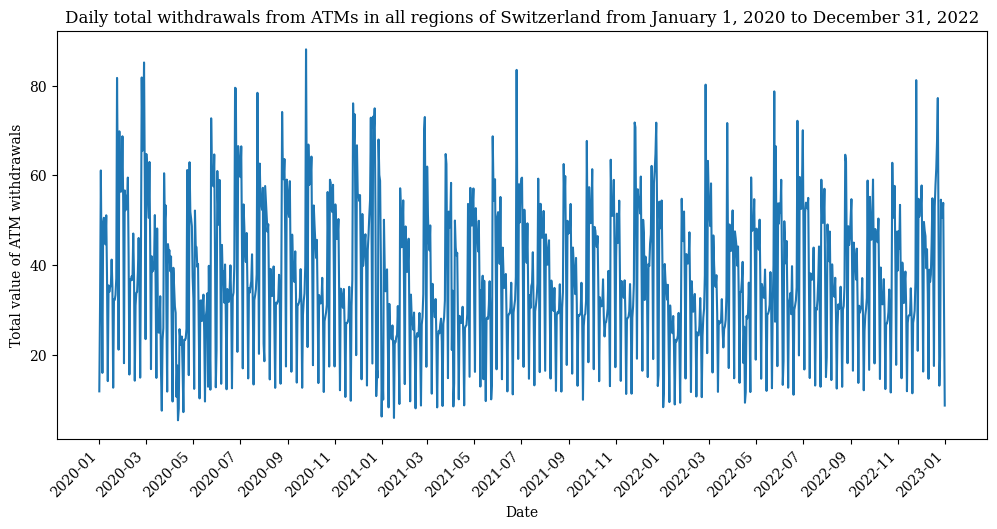

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(country_data['ds'], country_data['y']) #, color='b')
plt.xlabel('Date')
plt.ylabel('Total value of ATM withdrawals')
plt.title('Daily total withdrawals from ATMs in all regions of Switzerland from January 1, 2020 to December 31, 2022')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate(rotation=45)
plt.show()

The time series plot suggests no clear upward or downward trend in the total cash withdrawn in Switzerland. There may be a pattern where cash withdrawals from ATMs appear lower in the early months of the year, followed by a very slight increase in subsequent months. 

Additionally, there is a noticeable decline at the beginning of 2020, starting in March, reaching a minimum around mid-April, and then returning to previous levels in May. This slowdown aligns with the spread of the coronavirus across Europe, with the first case recorded in Switzerland in late February, followed by an increase in infections.

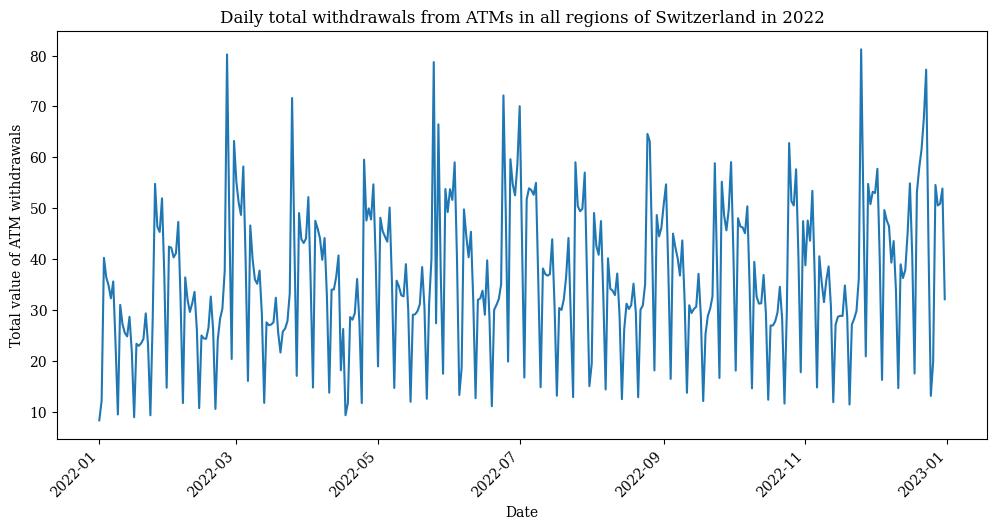

In [11]:
country_data_2022 = country_data[(country_data['ds'] >= '2022-01-01') & (country_data['ds'] <= '2022-12-31')]

plt.figure(figsize=(12, 6))
plt.plot(country_data_2022['ds'], country_data_2022['y']) #, color='b')
plt.xlabel('Date')
plt.ylabel('Total value of ATM withdrawals')
plt.title('Daily total withdrawals from ATMs in all regions of Switzerland in 2022')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate(rotation=45)
plt.show()

The chart indicates seasonal patterns, with **recurring cycles on both a weekly and monthly basis**. Throughout the week, there is a noticeable trend where ATM withdrawals reach their highest levels on particular days. Furthermore, withdrawal amounts often rise toward the end of each month and then gradually decline over the following 3-4 weeks, while still showing regular fluctuations related to weekly cycles. Additionally, certain prominent peaks are visible on the chart, which do not follow the weekly cycle.

*Note: The charts below are interactive, allowing for a more detailed exploration of the data and identification of patterns through zooming.*

In [12]:
regions= ['region1', 'region2', 'region3', 'region4', 'region5', 'region6', 'region7']

StatsForecast.plot(data, unique_ids=regions)

## Basic descriptive statistics

Basic descriptive statistics of time series for each level of hierarchy are shown below.

In [13]:
# Define the custom statistics function
def calculate_statistics(series, digits=3):
    """Calculate descriptive statistics for a given pandas Series."""
    return {
        'Minimum': round(series.min(), digits),
        'Mean': round(series.mean(), digits),
        'Median': round(series.median(), digits),
        'Maximum': round(series.max(), digits),
        'Standard Deviation': round(series.std(), digits),
        'Coefficient of Variation [%]': round((series.std() / series.mean()) * 100, digits)
    }

# Calculate statistics for each group
statistics = {
    'Country': calculate_statistics(country_data['y']),
    'Regions': calculate_statistics(regions_data['y']),
    'Cantons': calculate_statistics(cantons_data['y'])
}

# Create a DataFrame for the statistics
stats_table = pd.DataFrame(statistics)

print(stats_table)

                              Country  Regions  Cantons
Minimum                         5.400    0.174    0.004
Mean                           36.976    5.282    1.422
Median                         35.475    4.697    0.732
Maximum                        88.088   22.532   15.107
Standard Deviation             15.492    3.196    1.775
Coefficient of Variation [%]   41.896   60.504  124.810


A higher coefficient of variation indicates greater variability in the data relative to its mean. In hierarchical data analysis, where the data is grouped by different levels of hierarchy, differences in the coefficient of variation can be observed depending on the level. The lower the level, the higher the variability of the time series. A high coefficient may suggest irregular or unpredictable payout patterns. When there are fewer ATMs described by a time series, even small changes in the number and size of transaction volumes can lead to significant variability. In the case of a larger number of ATMs, such as on a national scale, individual cases of noise or outliers can be averaged out by other observations. As a result, the total amount of money withdrawn at the national level may exhibit more stable patterns, representative of broader trends and customer behaviors, which are less sensitive to the influence of individual events.

## Calendar effects

In the context of forecasting ATM withdrawals, calendar effects play a crucial role in the analysis. The amount of cash withdrawals may depend on the day of the week, the day of the month, or the month itself due to factors such as consumer behavior, payment cycles, and seasonal spending changes. Additionally, public holidays are an important aspect of this analysis, as they often lead to reduced withdrawals due to store and ATM closures, as well as reduced demand for cash during holiday periods.

The following types of calendar effects will be examined:

- day of the week
- day of the month
- month of the year
- public holidays

**Day of the week, day of the month, month of the year**

The following figures present box plots of cash withdrawals from ATMs in Switzerland by day of the week, day of the month and month number of the year.

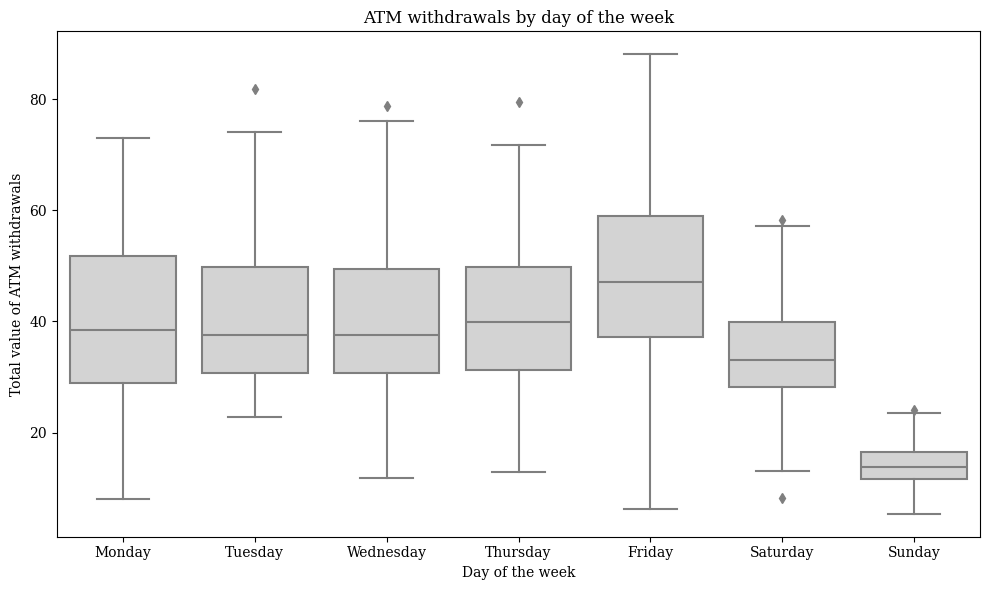

In [14]:
# Add a column for the day of the week (0 = Monday, 6 = Sunday)
country_data['weekday'] = country_data['ds'].dt.day_name()

# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='weekday', y='y', data=country_data, color='lightgray', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xlabel('Day of the week')
plt.ylabel('Total value of ATM withdrawals')
plt.title('ATM withdrawals by day of the week')
plt.tight_layout()
plt.show()

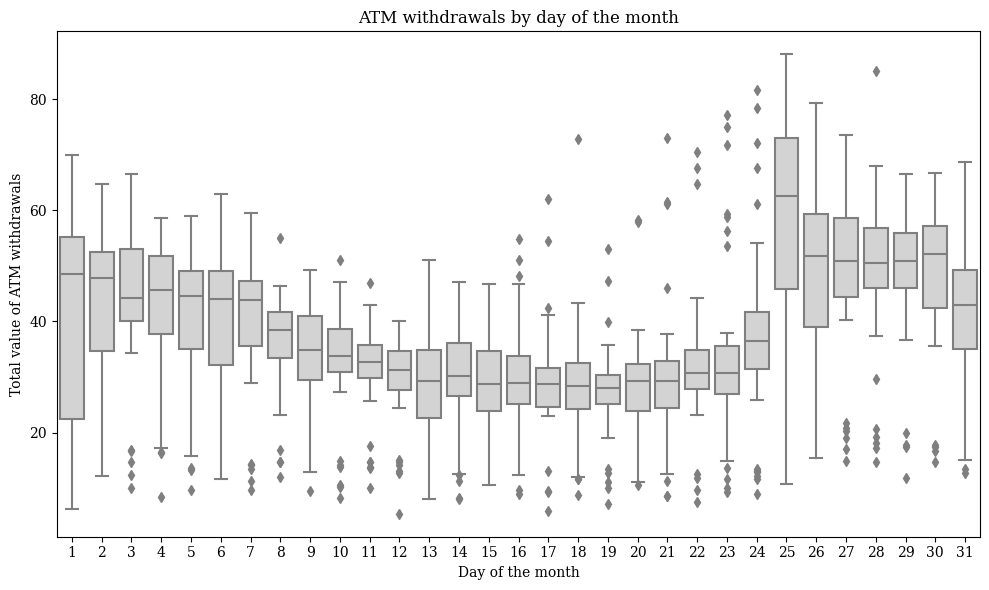

In [15]:
# Add a column for the day of the week (0 = Monday, 6 = Sunday)
country_data['day_of_month'] = country_data['ds'].dt.day

# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='day_of_month', y='y', data=country_data, color='lightgray')
plt.xlabel('Day of the month')
plt.ylabel('Total value of ATM withdrawals')
plt.title('ATM withdrawals by day of the month')
plt.tight_layout()
plt.show()

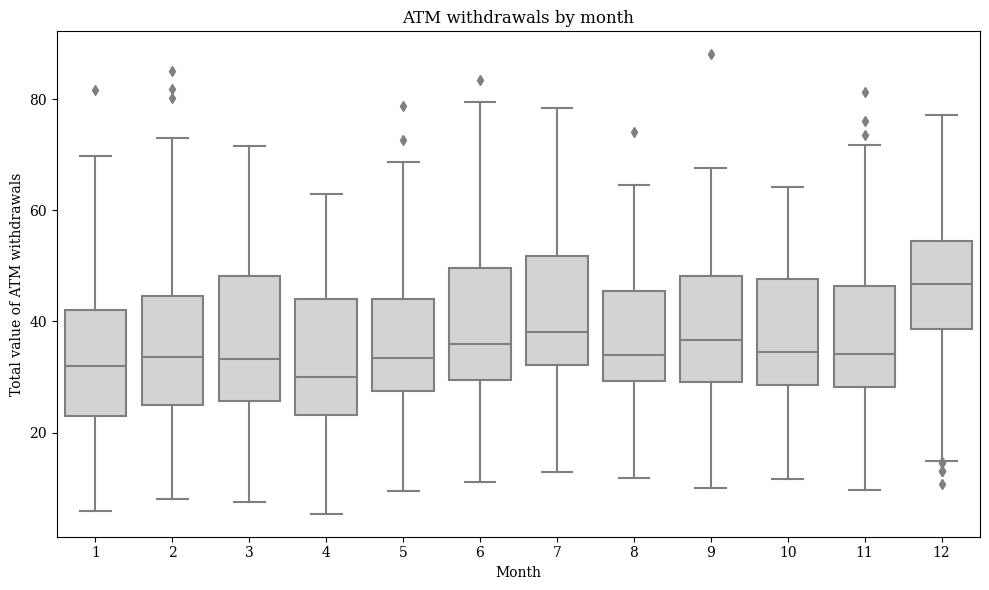

In [16]:
# Add a column for the day of the week (0 = Monday, 6 = Sunday)
country_data['month'] = country_data['ds'].dt.month

# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='month', y='y', data=country_data, color='lightgray')
plt.xlabel('Month')
plt.ylabel('Total value of ATM withdrawals')
plt.title('ATM withdrawals by month')
plt.tight_layout()
plt.show()

The following observations can be made:

- **day of the week** - The impact of the day of the week is clear – the average total cash withdrawn is highest on Fridays. These values significantly decrease over the weekend, reaching the lowest levels on Sundays. A wider boxplot for ATM withdrawals at the beginning of the week, particularly on Mondays, indicates greater variability in withdrawal amounts. 
- **day of the month and payday** - Boxplots show a noticeably higher level of withdrawals toward the end of each month, with the average peaking around the 25th. After this point, ATM withdrawals typically decline daily until the next cycle. This trend is influenced by Swiss payroll practices, as most employees are paid on or around the 25th of the month. A closer look at the 28 time series across the country, regions, and cantons 
reveals that peak withdrawals tend to shift from the 25th to the 24th or even the 23rd. This shift occurs because when the 25th falls on a weekend or public holiday, salaries are generally paid on the preceding business day. 
- **month of the year** - As for the month effect, there are no large changes. Minor fluctuations can be seen, but they aren’t particularly significant. A small increase is noted during the summer holiday period, though it’s minimal. December shows the highest levels in the boxplot, likely due to increased pre-holiday spending.

**Public holidays**

Another factor most likely to affect cash withdrawals is public holidays. Data was reviewed to identify holidays that likely influenced a decrease in withdrawals. The selected holidays are presented below.

<table>
    <tr>
        <th style="text-align: left;">Public holiday</th>
        <th>2020</th>
        <th>2021</th>
        <th>2022</th>
    </tr>
    <tr>
        <td style="text-align: left;">New Year</td>
        <td>January 1, 2020</td>
        <td>January 1, 2021</td>
        <td>January 1, 2022</td>
    </tr>
    <tr>
        <td style="text-align: left;">Good Friday</td>
        <td>April 10, 2020</td>
        <td>April 2, 2021</td>
        <td>April 15, 2022</td>
    </tr>
    <tr>
        <td style="text-align: left;">Easter Monday</td>
        <td>April 13, 2020</td>
        <td>April 5, 2021</td>
        <td>April 18, 2022</td>
    </tr>
    <tr>
        <td style="text-align: left;">Ascension Day</td>
        <td>May 21, 2020</td>
        <td>May 13, 2021</td>
        <td>May 26, 2022</td>
    </tr>
    <tr>
        <td style="text-align: left;">Whit Monday</td>
        <td>June 1, 2020</td>
        <td>May 24, 2021</td>
        <td>June 6, 2022</td>
    </tr>
    <tr>
        <td style="text-align: left;">Swiss National Day</td>
        <td>August 1, 2020</td>
        <td>August 1, 2021</td>
        <td>August 1, 2022</td>
    </tr>
    <tr>
        <td style="text-align: left;">Christmas Day</td>
        <td>December 25, 2020</td>
        <td>December 25, 2021</td>
        <td>December 25, 2022</td>
    </tr>
    <tr>
        <td style="text-align: left;">St. Stephen's Day</td>
        <td>December 26, 2020</td>
        <td>December 26, 2021</td>
        <td>December 26, 2022</td>
    </tr>
</table>


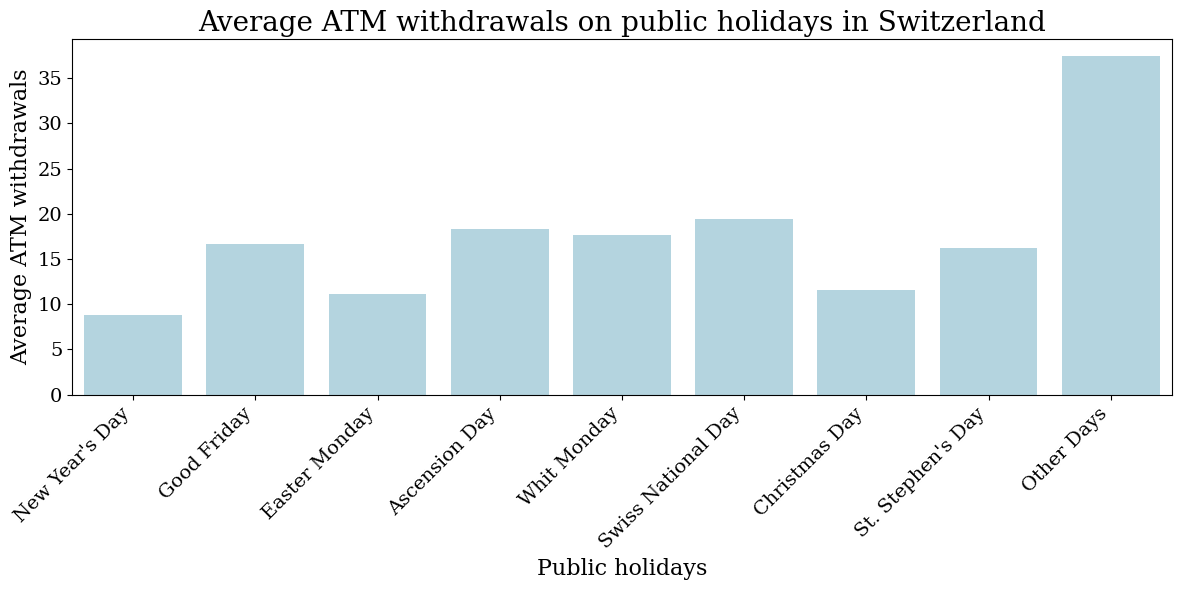

In [17]:
# Define public holidays
public_holidays = pd.DataFrame({
    'ds': ["2020-01-01", "2020-04-10", "2020-04-13", "2020-05-21", "2020-06-01", "2020-08-01", "2020-12-25", "2020-12-26",
             "2021-01-01", "2021-04-02", "2021-04-05", "2021-05-13", "2021-05-24", "2021-08-01", "2021-12-25", "2021-12-26",
             "2022-01-01", "2022-04-15", "2022-04-18", "2022-05-26", "2022-06-06", "2022-08-01", "2020-12-25", "2020-12-26"],
    'ph_name': ["New Year's Day", "Good Friday", "Easter Monday", "Ascension Day", 
                "Whit Monday", "Swiss National Day", "Christmas Day", "St. Stephen's Day",
                "New Year's Day", "Good Friday", "Easter Monday", "Ascension Day", 
                "Whit Monday", "Swiss National Day", "Christmas Day", "St. Stephen's Day",
                "New Year's Day", "Good Friday", "Easter Monday", "Ascension Day", 
                "Whit Monday", "Swiss National Day", "Christmas Day", "St. Stephen's Day"]
})

# Convert 'date' to datetime format
public_holidays['ds'] = pd.to_datetime(public_holidays['ds'])

# Merge public holidays with country_data on 'date'
merged_data = pd.merge(country_data, public_holidays, on='ds', how='left')

# Fill NA values in 'ph_name' with 'Other Days'
merged_data['ph_name'] = merged_data['ph_name'].fillna('Other Days')

# Ensure 'ph_name' is a categorical variable with a specific order
merged_data['ph_name'] = pd.Categorical(merged_data['ph_name'], 
    categories=["New Year's Day", "Good Friday", "Easter Monday", 
                "Ascension Day", "Whit Monday", "Swiss National Day", 
                "Christmas Day", "St. Stephen's Day", "Other Days"],
    ordered=True)

# Create the plot
plt.figure(figsize=(12, 6))
sns.barplot(x='ph_name', y='y', data=merged_data, estimator='mean', errorbar=None, color='lightblue')

# Customize labels and titles
plt.xlabel('Public holidays', fontsize=16)
plt.ylabel('Average ATM withdrawals', fontsize=16)
plt.title('Average ATM withdrawals on public holidays in Switzerland', fontsize=20)

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=14)

# Display the plot
plt.tight_layout()
plt.show()

Graph clearly illustrates the decline in money withdrawals on selected holidays.

## Seasonality

**Power Spectral Density (PSD)**

Spectral density analysis was used to examine the seasonality of the data. Below figure shows the **naive periodograms** for the series on total cash withdrawals in Switzerland. Naive periodograms are a simple way to estimate the frequency content of a time series by analyzing how much "power" is present at different frequencies.

In [18]:
# Calculate the periodogram (power spectral density)
frequencies, power_density = periodogram(country_data['y'], fs=1)  # fs=1 for daily data (1 cycle per day)

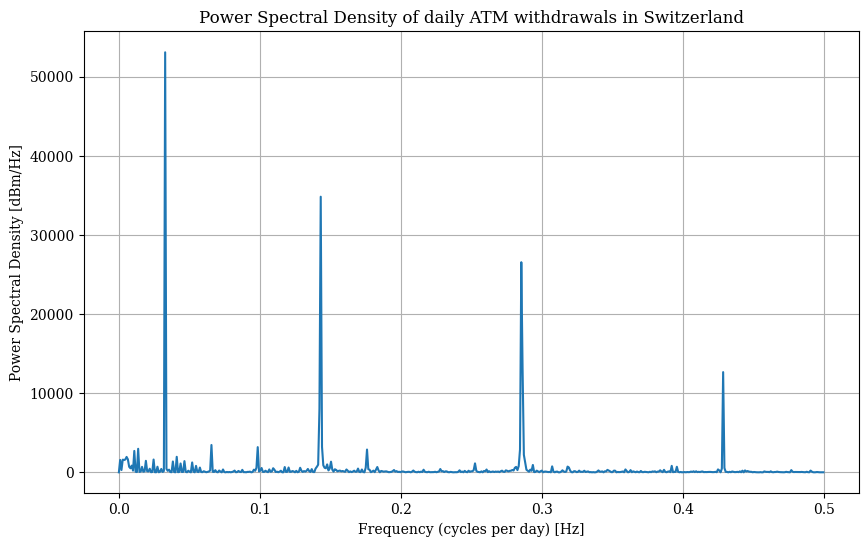

In [19]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(frequencies, power_density)
plt.title("Power Spectral Density of daily ATM withdrawals in Switzerland")
plt.xlabel("Frequency (cycles per day) [Hz]")
plt.ylabel("Power Spectral Density [dBm/Hz]")
plt.grid(True)
plt.show()

In [20]:
# Find indices of the 5 largest power densities
top_n = 5
top_indices = np.argsort(power_density)[-top_n:][::-1]  # Sort in descending order

top_frequencies = frequencies[top_indices]
top_power_densities = power_density[top_indices]

print("Top Frequencies and Power Densities:")
for i in range(top_n):
    cycle_days = 1 / top_frequencies[i] if top_frequencies[i] != 0 else np.inf  # Convert frequency to cycle days
    print(f"Frequency: {top_frequencies[i]:.4f} cycles/day, Power Density: {top_power_densities[i]:.4f}, Cycle in days (approx): {cycle_days:.2f} days")

Top Frequencies and Power Densities:
Frequency: 0.0328 cycles/day, Power Density: 53114.2370, Cycle in days (approx): 30.47 days
Frequency: 0.1431 cycles/day, Power Density: 34853.8148, Cycle in days (approx): 6.99 days
Frequency: 0.2853 cycles/day, Power Density: 26569.1300, Cycle in days (approx): 3.50 days
Frequency: 0.2862 cycles/day, Power Density: 13053.5790, Cycle in days (approx): 3.49 days
Frequency: 0.4284 cycles/day, Power Density: 12671.1428, Cycle in days (approx): 2.33 days


- The highest peak occurs for a frequency equal to 0.0328, which corresponds to about 30,472 days, or a monthly cycle. 

- The second peak on the plot occurs for a frequency equal to 0.1423 and 0.1432, indicating a period of 7.03 and 6,98 days respectively, or a weekly cycle. 

- An increase in spectral density for frequencies of 0.285 and 0.428 corresponds to periods of 3.5 days and 2.33 days, respectively. Both of these are the so called harmonics - The term “harmonic” means that these frequencies are multiples of the fundamental frequency, which in this case is the 7-day period. Harmonic frequencies indicate that there is a weekly periodicity in the data, but it does not have a sinusoidal shape. In other words, there is a repeating pattern every 7 days, but it is not perfectly regular like a sine wave, which may suggest some irregularity in the time cycle. 

**Autocorrelation and partial autocorrelation functions (ACF, PACF)**

In the context of studying the seasonality of the data, an analysis of the autocorrelation function (ACF) and the partial autocorrelation function (PACF) was also carried out, using the time series of daily withdrawals for the whole of Switzerland, which are particularly useful in identifying general autocorrelation patterns.

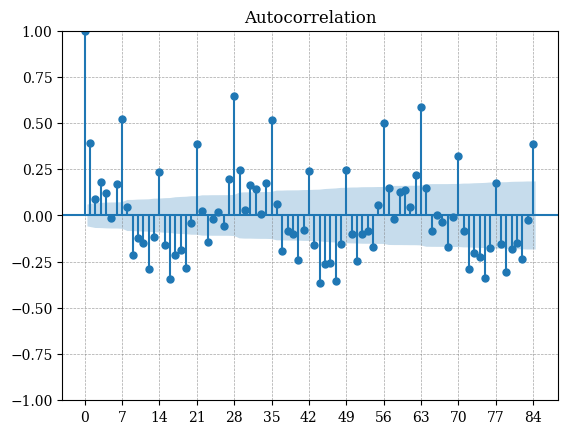

In [21]:
plot_acf(country_data['y'], lags=7*12)
plt.xticks(ticks=range(0, 7*12+1, 7), labels=range(0, 7*12+1, 7))
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

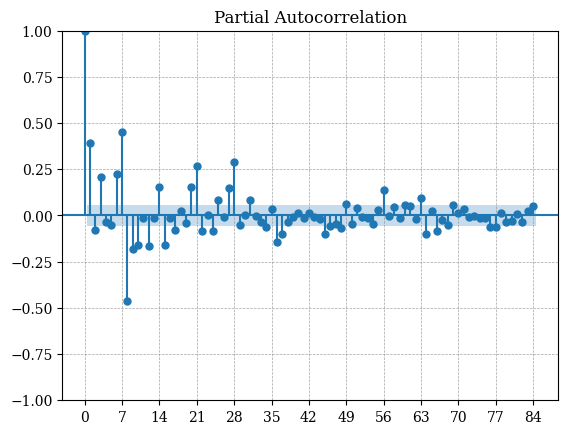

In [22]:
plot_pacf(country_data['y'], lags=7*12)
plt.xticks(ticks=range(0, 7*12+1, 7), labels=range(0, 7*12+1, 7))
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

The ACF shows regular **spikes at lags that are multiples of 7**, indicating **weekly seasonality** in the dataset. Similarly, the PACF has high values for every 7th lag but decreases more sharply compared to the ACF as the lags increase. Additionally, the high value at lag 28 suggests a recurring cycle approximately every four weeks, a pattern consistent across other time series in the dataset.

# Models development

## Metodology

To forecast ATM withdrawals, two models were built:

- global model and
- local model.

In the case of building **local models**, an approach was used in which a separate forecasting model was created for each time series (for the respective regions, cantons, and for the country) individually. As the data analysis clearly indicated the presence of **complex seasonality** (meaning the existence of more than one cycle in the data i.e. repetitive patterns were observed at both weekly and monthly levels) capturing and modeling such characteristics of the time series can be achieved using **harmonic regression** models that incorporate Fourier components and ARMA (Autoregressive Moving Average) errors.

In contrast to the local approach, where separate models are built for each time series in the dataset, the **global model** assumes the use of a single, common model for all series simultaneously. The **LightGBM** algorithm was used to build the global model.

To evaluate the performance of both local and global model, a **naive seasonal method** was used (for the analyzed data, weekly seasonality was utilized, meaning that the forecasts at a given time were equal to the observations from 7 days prior).

In case of both approaches, the dataset was divided into two parts: a training set and a test set. The test set, which covered the period from October 1 to December 31, 2022, resulted in a forecast horizon of 92 days.

## Global model - LightGBM

The global model assumes the usage of one common model for all data from observations across all levels of the hierarchy. In time series forecasting, global models learn patterns from multiple time series simultaneously, rather than treating each series independently as in local models. The same evaluated model is used to generate forecasts for all time series. In this case, the global model employs a machine learning technique **LightGBM**, which is a gradient boosting framework that is particularly effective for large datasets and complex patterns.

To evaluate the forecasts for the test set, the **recursive  multi-step forecasting** method is used, where the model initially predicts one time step ahead and then uses each subsequent forecast as input for the following time step. The process continues recursively until the desired forecast horizon is reached, with the model being retrained after each step using the updated training dataset.

### Data processing and transformation

Before building and training the final form of the model, a process of **selecting appropriate explanatory variables** was carried out. Based on the conclusions of the data analysis in previous steps, the variables that were taken into account are:
- Lagged variables. Lagged variables can prove crucial in modeling ATM withdrawals, allowing the model to account for the impact of previous periods on current behavior. Given the conclusions drawn from the analysis of the graphs of the ACF and the detected weekly and monthly seasonality, it was decided to choose lags for the 7th, 14th, 21st and 28th days. In addition, the values observed for the same date in the previous year were also taken into account.
- A binary variable determining whether a given day was a payday. In situations where the 25th day of the month fell on a public holiday or weekend, the closest working day preceding that date was taken as the payday.
- Binary variable indicating whether the day was a public holiday.
- Region. A variable specifying the region from which the observation originated.
- Month of the year.
- Day of the week.

For categorical variables, **One-Hot Encoding** was applied, and one category was removed to avoid the **dummy variable trap**. Numerical data was normalized using **Min-Max** scaling, fitted to the training set, and applied to scale the test set.

#### Create qualitative explanatory variables

In [23]:
# Payment Days
paydays = [
    "2020-01-24", "2020-02-25", "2020-03-25", "2020-04-24", "2020-05-25", 
    "2020-06-25", "2020-07-24", "2020-08-25", "2020-09-25", "2020-10-23", 
    "2020-11-25", "2020-12-24", "2021-01-25", "2021-02-25", "2021-03-25", 
    "2021-04-23", "2021-05-25", "2021-06-25", "2021-07-23", "2021-08-25", 
    "2021-09-24", "2021-10-25", "2021-11-25", "2021-12-24", "2022-01-25", 
    "2022-02-25", "2022-03-25", "2022-04-25", "2022-05-25", "2022-06-24", 
    "2022-07-25", "2022-08-25", "2022-09-23", "2022-10-25", "2022-11-25", 
    "2022-12-23"
]

# Public Holidays
public_holidays = [
    "2020-01-01", "2020-04-10", "2020-04-13", "2020-05-21", "2020-06-01", 
    "2020-08-01", "2020-12-25", "2020-12-26", "2021-01-01", "2021-04-02", 
    "2021-04-05", "2021-05-13", "2021-05-24", "2021-08-01", "2021-12-25", 
    "2021-12-26", "2022-01-01", "2022-04-15", "2022-04-18", "2022-05-26", 
    "2022-06-06", "2022-08-01", "2022-12-25", "2022-12-26"
]

# Assign category based on unique_id
data['category'] = data['unique_id'].str.split('-').str[0].replace('total', 'country')

# Calendar Variables
data['day_of_week'] = data['ds'].dt.dayofweek  # Day of the week
data['payday'] = data['ds'].isin(paydays).astype(int)  # Payment day indicator
data['month'] = data['ds'].dt.month  # Month number
data['public_holiday'] = data['ds'].isin(public_holidays).astype(int)  # Public holiday indicator

# One-hot encoding for month and category
data = pd.get_dummies(data, columns=['month', 'category'], drop_first=True)

# One-hot encoding for day of the week, excluding Wednesday
data = pd.get_dummies(data, columns=['day_of_week'], drop_first=False)
data = data.drop(columns=['day_of_week_2'])  # Drop Wednesday (index 2)

data.head(3)

ds unique_id          y  payday  public_holiday  month_2  month_3  \
0 2020-01-01     total  11.845225       0               1    False    False   
1 2020-01-02     total  31.837222       0               0    False    False   
2 2020-01-03     total  61.089340       0               0    False    False   

   month_4  month_5  month_6  ...  category_region4  category_region5  \
0    False    False    False  ...             False             False   
1    False    False    False  ...             False             False   
2    False    False    False  ...             False             False   

   category_region6  category_region7  day_of_week_0  day_of_week_1  \
0             False             False          False          False   
1             False             False          False          False   
2             False             False          False          False   

   day_of_week_3  day_of_week_4  day_of_week_5  day_of_week_6  
0          False          False          False          False  
1           True          False          False          False  
2          False           True          False          False  

[3 rows x 29 columns]

#### Split into training and testing sets

In [24]:
data.reset_index(drop=True, inplace=True)

# Create the training dataset - data before October 1, 2022
train_data = data[data['ds'] < pd.to_datetime("2022-10-01")].copy()

# Create the testing dataset - data from October 1, 2022, onwards
test_data = data[data['ds'] >= pd.to_datetime("2022-10-01")].copy()

#### Min-Max Scalling

In [25]:
numeric_cols = ['y']

scaler = MinMaxScaler()

# Fit the scaler to the training data
scaler.fit(train_data[numeric_cols])

# Transform the training data using the fitted scaler
train_data[numeric_cols] = scaler.transform(train_data[numeric_cols])

#### Add lagged features

In [26]:
# Define a function to add lagged variables for a time series
def add_lag_columns(data, lag_values):
    for lag in lag_values:
        # Add columns for lagged values based on the specified lag days
        data[f'y_lag{lag}'] = data.groupby('unique_id')['y'].shift(lag)

# Add columns with lags of 7, 14, 21, and 28 days
add_lag_columns(train_data, lag_values=[7, 14, 21, 28])

# Add observations from the same date one year ago
train_data['ds_last_year'] = train_data.groupby('unique_id')['ds'].apply(lambda x: x - pd.DateOffset(years=1)).reset_index(level=0, drop=True)
train_data = train_data.merge(train_data[['ds', 'y', 'unique_id']], 
                              how='left', 
                              left_on=['unique_id', 'ds_last_year'], 
                              right_on=['unique_id', 'ds'], 
                              suffixes=('', '_last_year'))

# Drop the 'ds_last_year' column after merging
train_data.drop(columns='ds_last_year', inplace=True)

# Remove rows with NaN values
train_data.dropna(inplace=True)

#### Data type conversion

In [27]:
# Convert numeric columns to float
numeric_cols = ['y','y_lag7', 'y_lag14', 'y_lag21', 'y_lag28','y_last_year']

for col in numeric_cols:
    train_data[col] = train_data[col].astype('float')

# Convert categorical columns to category type
obj_cols = ['payday', 'public_holiday', 'day_of_week_1', 'day_of_week_0',
       'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'category_region1', 'category_region2', 'category_region3',
       'category_region4', 'category_region5', 'category_region6',
       'category_region7']

for col in obj_cols:
    train_data[col] =  train_data[col].astype('category').cat.codes

### Selection of explanatory variables

To select the explanatory variables for the model, **Feature Importance** analysis and **Recursive Feature Elimination** technique were used.

The variable selection and model training process was based on **rolling origin cross-validation**, which is particularly useful for sequential data, such as time series, where the forecasting origin is repeatedly moved forward by a fixed number of observations. The data were split into 4 subsets, with each validation set containing 90 observations, and the in-sample size was configured to increase with each step in this approach. **Hyperparameter optimization** was performed using the **random search technique**, and the model's performance was evaluated using the **root mean squared error (RMSE**).

#### Cross-validation for feature selection setup

In [28]:
# Create a copy of the training data and filter out duplicated time series
df_train = train_data.copy()
df_train = df_train[~df_train['unique_id'].isin(['region4-cantonZH', 'region7-cantonTI'])]

# Set the 'ds' column as the index
df_train.set_index('ds', inplace=True)

# Separate features and target variable
X_train = df_train.drop(columns=['unique_id', 'y'])
y_train = df_train['y']

# Sort the unique dates in ascending order
dates = np.sort(X_train.index.unique())

# Define 4 rolling origin cross-validation folds with a test set size of 90 days
tscv = TimeSeriesSplit(n_splits=4, test_size = 90).split(dates)
my_cv = [(train,test) for train, test in tscv]

# Print the splits to verify
# for train_index, test_index in my_cv:
#     print("TRAIN:", train_index, "TEST:", test_index)

In [29]:
def randomized_search_lgb(X, y, n_iterations, cv_folds, scoring='neg_root_mean_squared_error', random_state=None):
    """
    Perform hyperparameter tuning for a LightGBM model using RandomizedSearchCV.
    
    Parameters:
        X (array-like): Feature matrix.
        y (array-like): Target variable.
        n_iterations (int): Number of iterations for RandomizedSearchCV.
        cv_folds (list of tuples): Custom cross-validation folds, where each tuple contains the indices of the training and test sets for each fold in a rolling-origin cross-validation.
        scoring (str): Scoring metric for optimization. Default is 'neg_root_mean_squared_error'.
        random_state (int, optional): Random seed for reproducibility. Default is None.
    
    Returns:
    RandomizedSearchCV: Fitted model with the best hyperparameters.
    """
    
    random.seed(random_state)  # Set random seed for reproducibility
    np.random.seed(random_state)
    
    # Define the LightGBM model
    lgb_model = lgb.LGBMRegressor()
    
    # Hyperparameter grid for tuning
    param_search = {
        'num_leaves': stats.randint(20, 100),  # Number of leaves in the tree
        'learning_rate': stats.uniform(0.001, 0.3),  # Range for learning rate from 0.001 to 0.3
        'max_depth': stats.randint(1, 100),  # Maximum depth of the tree
        'feature_fraction': stats.uniform(0.5, 0.4),  # Fraction of features to consider (0.5 to 0.9)
        'bagging_fraction': stats.uniform(0.5, 0.4),  # Fraction of data to be used for bagging (0.5 to 0.9)
        'bagging_freq': stats.randint(5, 9),  # Frequency of bagging
        'lambda_l1': stats.uniform(0.0, 10.0),  # L1 regularization term
        'lambda_l2': stats.uniform(0.0, 10.0),  # L2 regularization term
        'min_child_samples': stats.randint(1, 100),  # Minimum number of samples per leaf
        'n_estimators': stats.randint(100, 500),  # Number of boosting iterations
        'verbose': [-1],  # Verbosity of output
        'boosting_type': ['gbdt'],  # Type of boosting (Gradient Boosting Decision Tree)
    }
    
    # Initialize RandomizedSearchCV for hyperparameter tuning
    randomized_search = RandomizedSearchCV(estimator=lgb_model, n_iter=n_iterations, cv=cv_folds, param_distributions=param_search, scoring=scoring)
    
    # Fit the model with the best hyperparameters to the data
    randomized_search.fit(X, y)
    
    # Print the best hyperparameters and lowest RMSE found
    print("Best parameters found: ", randomized_search.best_params_)
    print("Lowest RMSE found: ", (-randomized_search.best_score_) ** 0.5)
    
    return randomized_search  # Return the fitted model with the best parameters

In [30]:
# Perform random randomized search
randomized_search_lgb_tuned = randomized_search_lgb(X_train, y_train, n_iterations = 500, cv_folds=my_cv, scoring='neg_root_mean_squared_error', random_state=10)
best_params = randomized_search_lgb_tuned.best_params_
best_params

Best parameters found:  {'bagging_fraction': 0.6691269159305732, 'bagging_freq': 8, 'boosting_type': 'gbdt', 'feature_fraction': 0.5079409898732845, 'lambda_l1': 0.2559470807759545, 'lambda_l2': 8.579156589575666, 'learning_rate': 0.04308855309793873, 'max_depth': 4, 'min_child_samples': 2, 'n_estimators': 462, 'num_leaves': 59, 'verbose': -1}
Lowest RMSE found:  0.25117667280751504


{'bagging_fraction': 0.6691269159305732,
 'bagging_freq': 8,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.5079409898732845,
 'lambda_l1': 0.2559470807759545,
 'lambda_l2': 8.579156589575666,
 'learning_rate': 0.04308855309793873,
 'max_depth': 4,
 'min_child_samples': 2,
 'n_estimators': 462,
 'num_leaves': 59,
 'verbose': -1}

In [31]:
# Fit the LightGBM model using the best hyperparameters
gbm_model = lgb.LGBMRegressor(**best_params)
gbm_model.fit(X_train, y_train)  # Train the model on the training data

LGBMRegressor(bagging_fraction=0.6691269159305732, bagging_freq=8,
              feature_fraction=0.5079409898732845, lambda_l1=0.2559470807759545,
              lambda_l2=8.579156589575666, learning_rate=0.04308855309793873,
              max_depth=4, min_child_samples=2, n_estimators=462, num_leaves=59,
              verbose=-1)

#### Feature Importance

In [32]:
# Extract feature importance
fea_imp_ = pd.DataFrame({'cols': X_train.columns, 'fea_imp': gbm_model.feature_importances_})

# Sort descending
fea_imp_sorted = fea_imp_.loc[fea_imp_.fea_imp > 0].sort_values(by=['fea_imp'], ascending=False)

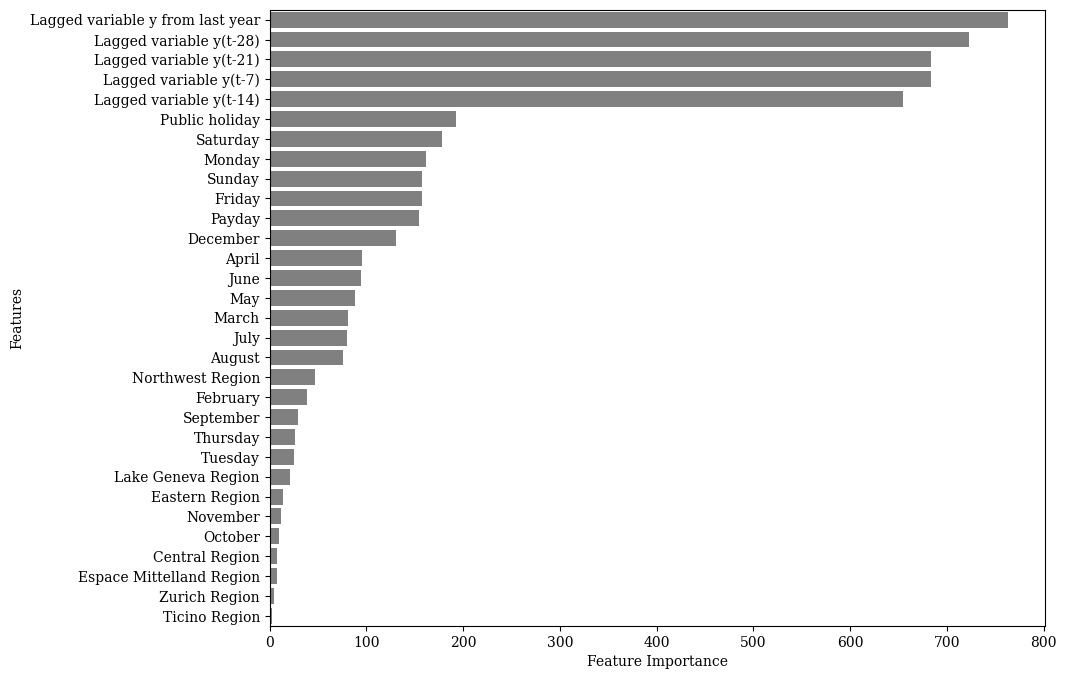

In [33]:
# Remap variable names
mapping = {
    'payday': 'Payday',
    'public_holiday': 'Public holiday',
    'month_2': 'February',
    'month_3': 'March',
    'month_4': 'April',
    'month_5': 'May',
    'month_6': 'June',
    'month_7': 'July',
    'month_8': 'August',
    'month_9': 'September',
    'month_10': 'October',
    'month_11': 'November',
    'month_12': 'December',
    'category_region1': 'Lake Geneva Region',
    'category_region2': 'Espace Mittelland Region',
    'category_region3': 'Northwest Region',
    'category_region4': 'Zurich Region',
    'category_region5': 'Eastern Region',
    'category_region6': 'Central Region',
    'category_region7': 'Ticino Region',
    'y_lag7': 'Lagged variable y(t-7)',
    'y_lag14': 'Lagged variable y(t-14)',
    'y_lag21': 'Lagged variable y(t-21)',
    'y_lag28': 'Lagged variable y(t-28)',
    'y_last_year': 'Lagged variable y from last year',
    'day_of_week_0': 'Monday',
    'day_of_week_1': 'Tuesday',
    'day_of_week_3': 'Thursday',
    'day_of_week_4': 'Friday',
    'day_of_week_5': 'Saturday',
    'day_of_week_6': 'Sunday'
}
fea_imp_sorted['cols'] = fea_imp_sorted['cols'].map(mapping)

plt.figure(figsize=(10, 8))
sns.barplot(x='fea_imp', y='cols', data=fea_imp_sorted, color='grey') 
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.show()

#### Recursive Feature Elimination (RFE)

In [34]:
# Initialize the LightGBM model with the best hyperparameters
gbm_model = lgb.LGBMRegressor(**best_params)

# Initialize Recursive Feature Elimination (RFE) with the model
rfe = RFE(gbm_model, n_features_to_select=1)

# Fit the RFE model on the training data
rfe = rfe.fit(X_train, y_train)

# Create a DataFrame to store feature names and their rankings
fea_rank_ = pd.DataFrame({'cols': X_train.columns, 'fea_rank': rfe.ranking_})

# Map column names
fea_rank_['cols'] = fea_rank_['cols'].map(mapping)

# Filter and sort features by their rank (ascending order)
fea_rank_.loc[fea_rank_.fea_rank >= 0].sort_values(by=['fea_rank'], ascending=True)

cols  fea_rank
30  Lagged variable y from last year         1
29           Lagged variable y(t-28)         2
26            Lagged variable y(t-7)         3
27           Lagged variable y(t-14)         4
28           Lagged variable y(t-21)         5
20                            Monday         6
0                             Payday         7
1                     Public holiday         8
24                          Saturday         9
23                            Friday        10
12                          December        11
25                            Sunday        12
4                              April        13
5                                May        14
6                               June        15
7                               July        16
8                             August        17
3                              March        18
2                           February        19
9                          September        20
21                           Tuesday        21
11                          November        22
15                  Northwest Region        23
17                    Eastern Region        24
22                          Thursday        25
13                Lake Geneva Region        26
10                           October        27
18                    Central Region        28
14          Espace Mittelland Region        29
16                     Zurich Region        30
19                     Ticino Region        31

The feature importance analysis clearly shows that all numerical variables stand out as key predictors. Among categorical variables, the most influential were those indicating whether a day is a public holiday or payday, as well as variables related to the days of the week. Variables like month and region number ranked the lowest. Based on these findings, the final model will include **all numerical features** expanded to include days like **Monday, Friday, Saturday** and **Sunday** due to potential fluctuations in weekly payout sums. **December** was also included, as it’s the holiday season, which is associated with higher spending and cash demand.

### Model evaluation and forecasting

For the final selected variables, the hyperparameter tuning process was repeated, and the final model was developed.

#### Hyperparameters tuning

In [35]:
# Define X_train, y_train, X_test, y_test datasets for processing
df_train = train_data.copy()
df_test = test_data.copy()

train_features_names = ['y_lag7', 'y_lag14', 'y_lag21', 'y_lag28', 'y_last_year','payday','public_holiday', 'day_of_week_0', 'day_of_week_4','day_of_week_5','day_of_week_6', 'month_12']
test_features_names = ['payday','public_holiday', 'day_of_week_0', 'day_of_week_4','day_of_week_5','day_of_week_6', 'month_12']

X_train = df_train[train_features_names] 
y_train = df_train['y']

X_test = df_test[test_features_names] 
y_test = df_test['y'] 

In [36]:
# Perform hyperparameter tuning
randomized_search_lgb_tuned = randomized_search_lgb(X_train, y_train, n_iterations = 500, cv_folds=my_cv, scoring='neg_root_mean_squared_error', random_state=42)
best_params = randomized_search_lgb_tuned.best_params_
best_params

Best parameters found:  {'bagging_fraction': 0.5967555534216584, 'bagging_freq': 6, 'boosting_type': 'gbdt', 'feature_fraction': 0.6349382187076371, 'lambda_l1': 0.19327630917601035, 'lambda_l2': 1.2436839900051022, 'learning_rate': 0.12509280247559057, 'max_depth': 25, 'min_child_samples': 3, 'n_estimators': 210, 'num_leaves': 36, 'verbose': -1}
Lowest RMSE found:  0.2503688514947901


{'bagging_fraction': 0.5967555534216584,
 'bagging_freq': 6,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.6349382187076371,
 'lambda_l1': 0.19327630917601035,
 'lambda_l2': 1.2436839900051022,
 'learning_rate': 0.12509280247559057,
 'max_depth': 25,
 'min_child_samples': 3,
 'n_estimators': 210,
 'num_leaves': 36,
 'verbose': -1}

#### Model evaluation and forecasting

In [37]:
def get_lagged_values(df, train_df, date):
    """
    This function adds lagged values of the target variable 'y' for the past 7, 14, 21, and 28 days 
    from the (updated) training DataFrame 'train_df' to the DataFrame 'df' based on the specified date.

    Parameters:
    df (DataFrame): The DataFrame to which lagged values will be added.
    train_df (DataFrame): The training DataFrame containing historical data and the newest forecasts for each unique identifier.
    date (Timestamp): The date used to filter historical records for calculating lagged values.

    Returns:
    DataFrame: The updated DataFrame 'df' with added lagged values.
    """
    
    for index, row in df.iterrows():
        # Retrieve the unique identifier for the current row
        unique_id = row['unique_id']

        # Calculate lagged values for the past 7, 14, 21, and 28 days
        df.loc[index, ['y_lag7']] = train_df[(train_df['unique_id'] == unique_id) & (train_df['ds'] < date)].tail(7)['y'].values[-7]
        df.loc[index, ['y_lag14']] = train_df[(train_df['unique_id'] == unique_id) & (train_df['ds'] < date)].tail(14)['y'].values[-14]
        df.loc[index, ['y_lag21']] = train_df[(train_df['unique_id'] == unique_id) & (train_df['ds'] < date)].tail(21)['y'].values[-21]
        df.loc[index, ['y_lag28']] = train_df[(train_df['unique_id'] == unique_id) & (train_df['ds'] < date)].tail(28)['y'].values[-28]
        
        # Retrieve the value of 'y' from the previous year for the same unique identifier
        previous_year_date = date - pd.DateOffset(years=1)
        df.loc[index, ['y_last_year']] = train_df[(train_df['unique_id'] == unique_id) & (train_df['ds'] == previous_year_date)]['y'].values

    return df

In [38]:
# Initialize and fit the model with the best parameters obtained from hyperparameter tuning
gbm_model = lgb.LGBMRegressor(**best_params)
gbm_model.fit(X_train, y_train)

# Predictions for the training set
train_preds = gbm_model.predict(X_train, num_iteration=gbm_model.best_iteration_)

# List of feature names to be used in the model
features_names = ['y_lag7', 'y_lag14', 'y_lag21', 'y_lag28', 'y_last_year',
                  'payday', 'public_holiday', 'day_of_week_0', 'day_of_week_4',
                  'day_of_week_5', 'day_of_week_6', 'month_12']

# Create a copy of the training DataFrame for updates
df_train_updated = df_train.copy()
df_train_updated.reset_index(drop=True, inplace=True)

# Initialize lagged value columns in the test DataFrame
df_test[['y_lag7', 'y_lag14', 'y_lag21', 'y_lag28', 'y_last_year']] = np.NaN

# Prepare a DataFrame to store forecasts for the test set
test_forecasts = pd.DataFrame(columns=['unique_id', 'ds', 'y'])

# Get unique dates from the test set to iterate over
dates = df_test['ds'].sort_values().unique()

# Loop through each date to predict values iteratively
for date in dates:
    # Select observations corresponding to the current date
    ith_observations = test_data[test_data['ds'] == date]

    # Update the explanatory variables by adding lagged values for the current date
    ith_observations_updated = get_lagged_values(ith_observations, df_train_updated, date)

    # Make predictions for the ith time step
    ith_observations_updated = ith_observations_updated.copy()
    ith_observations_updated['y'] = gbm_model.predict(ith_observations_updated[features_names])

    # Save predictions for the test set
    test_forecasts = test_forecasts._append(ith_observations_updated[['unique_id', 'ds', 'y']], ignore_index=True)

    # Update the training set with new observations
    df_train_updated = df_train_updated._append(ith_observations_updated, ignore_index=True)

    # Retrain the model on the updated training set
    gbm_model.fit(df_train_updated[features_names], df_train_updated['y'])

In [39]:
# LightGBM forecasts for train set
train_fcst_lightGBM = df_train[['unique_id','ds','y']].copy()
train_fcst_lightGBM.loc[:, 'lightGBM'] = train_preds

# LightGBM forecasts for test set
test_fcst_lightGBM = test_forecasts[['unique_id', 'ds', 'y']].copy()
test_fcst_lightGBM.rename(columns={'y': 'lightGBM'}, inplace=True) 
test_fcst_lightGBM.loc[:, 'lightGBM'] = pd.to_numeric(test_fcst_lightGBM['lightGBM'])

In [40]:
# Reverse Min-Max scaling transformation
train_fcst_lightGBM[['lightGBM', 'y']] = scaler.inverse_transform(train_fcst_lightGBM[['lightGBM', 'y']])
test_fcst_lightGBM['lightGBM'] = scaler.inverse_transform(test_fcst_lightGBM[['lightGBM']])

### Global model results

The figure below shows the **base forecasts** for the time series of the 7 NUTS regions and Switzerland.

In [41]:
def plot_forecasts(fcst_data, test_data, specified_ids, mapping, forecast_column, colors=['blue', 'green'], figsize=(10, 12)):
    """
    Plots harmonic regression forecasts and actual values for specified time series.

    Parameters:
    - harmonic_fcst (pd.DataFrame): Forecast data with columns ['ds', 'unique_id', forecast_column]
    - test_data (pd.DataFrame): Test data with columns ['ds', 'unique_id', 'y']
    - specified_ids (list): List of unique_id time series to include in the plot
    - mapping (dict): Mapping from unique_id to descriptive names of time series
    - forecast_column (str): Name of the forecast column in fcst_data
    - colors (list): List of colors to use for actual values and forecasts
    - figsize (tuple): Size of the figure
    
    Returns:
    - None: Displays the plot
    """
    # Merge forecast and test data
    plt_data = pd.merge(fcst_data, test_data, on=['ds', 'unique_id'], how='left')
    plt_data = plt_data[plt_data['unique_id'].isin(specified_ids)]

    # Map unique_id values to descriptive names
    plt_data['unique_id'] = plt_data['unique_id'].map(mapping)
    plt_data = plt_data.rename(columns=mapping, inplace=False)

    # Set up subplots
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=figsize)

    for i, (id_value, group) in enumerate(plt_data.groupby('unique_id')):
        # Define row and column for each subplot based on index
        if id_value == 'Switzerland':
            row, col = 0, 0
        else:
            row = (i - 1) // 2 + 1
            col = (i - 1) % 2
        
        # Plot data
        group.plot(x='ds', y=['y', forecast_column], ax=axes[row, col], title=f'{id_value}', color=colors)
        axes[row, col].set_xlabel('Date')
        axes[row, col].set_ylabel('ATM withdrawals')
        axes[row, col].legend(['Actual values', 'Forecasts'])

    plt.tight_layout()
    plt.show()

# Time series to being plotted
specified_ids = ['total', 'region1', 'region2', 'region3', 'region4', 'region5', 'region6', 'region7']

mapping = {
    'total': 'Switzerland',
    'region1': 'Lake Geneva region',
    'region2': 'Espace Mittelland',
    'region3': 'Northwestern Switzerland',
    'region4': ' Zurich Region',
    'region5': 'Eastern Switzerland',
    'region6': 'Central Switzerland',
    'region7': ' Ticino Region'
}

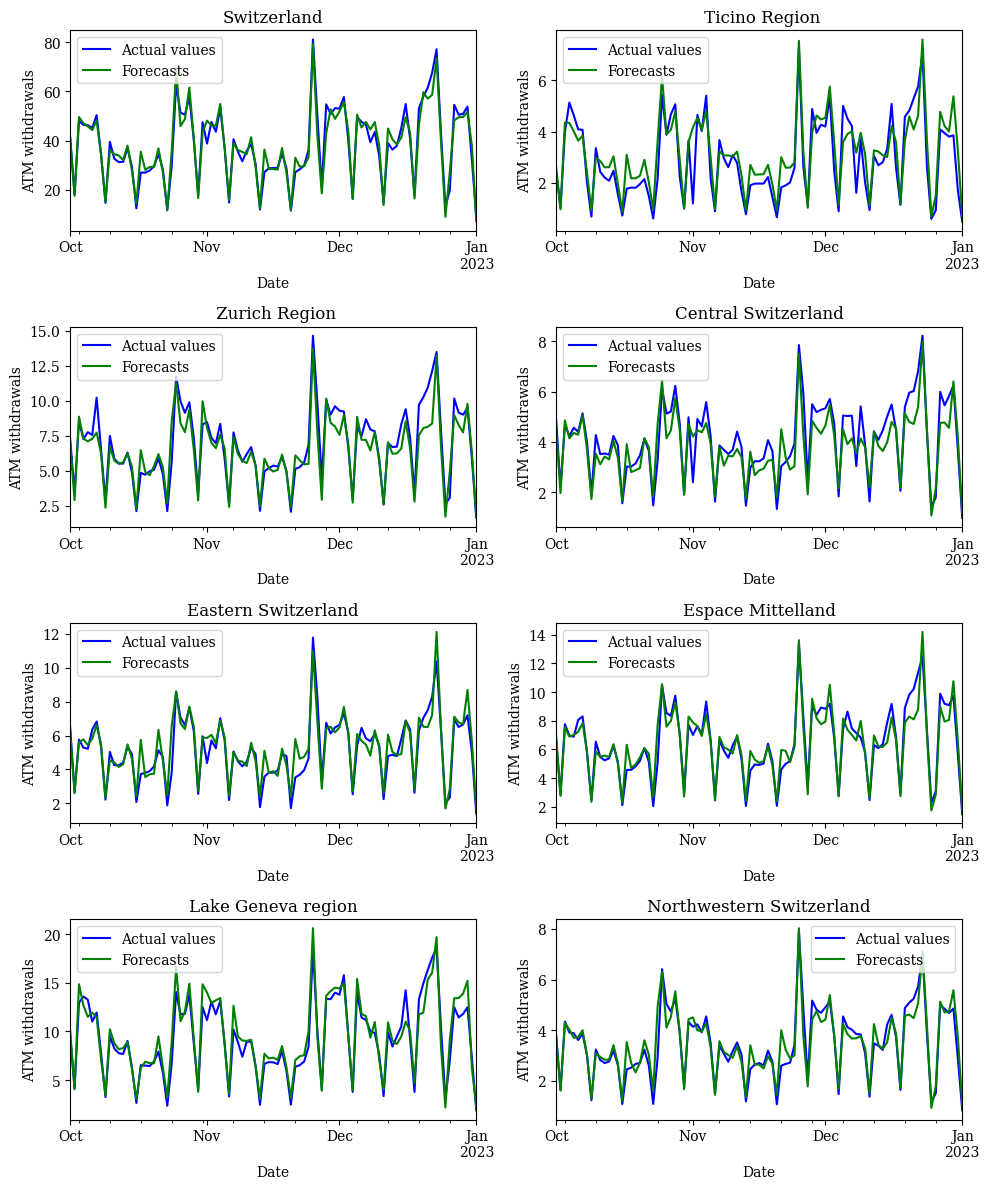

In [42]:
plot_forecasts(test_fcst_lightGBM, test_data, specified_ids, mapping, "lightGBM")

## Local model - Harmonic Regression

Local models assumes training and using **separate predictive models** for each time series in hierarchical stucture. Thus, individual forecasting models were developed for specific regions, cantons, and the country, capturing patterns unique to each time series. 

Based on the previous findings, the analyzed time series is characterized by **complex seasonality**, indicating the presence of more than one seasonal period - both weekly and monthly seasonality can be observed in the data. Therefore, the model used here is **dynamic harmonic regression** where the multiple seasonal patterns can be modelled using multiple Fourier terms with short-term time series dynamics handled by an ARMA error. The dynamic harmonic regression approach allows flexibility in modeling any length of seasonality by incorporating Fourier terms of various frequencies. The smoothness of the seasonal pattern can be adjusted by modifying the number of Fourier pairs (K), with smaller values of K resulting in a smoother seasonal pattern.

**Seasonality components**

Fourier components for **weekly and monthly cycles** were included. An additional **annual component** could also be considered, but with only three years of data and no strong low-frequency peaks in the periodograms, it's unclear if an annual cycle is actually present. To assess this, two harmonic regression models were built for each time series: one with only weekly and monthly components, and another including an annual component. The decision to include the annual term and selection of model's optimal parameters were based on the **Akaike Information Criterion (AIC)**.

**Parameters**

Before proceeding with comparison of two harmonic regression models (with and without inclusion of an annual component) for each time series, the model parameters were appropriately selected. The **parameter selection process** will be carried out individually for each time series, allowing its specific characteristics to be taken into account. The parameters used in the model training process are:
- **Number of harmonic components (𝑘)**:
The number of sine and cosine pairs for each harmonic component corresponding to a period 𝑡. A higher number of components can capture more complex seasonal patterns but may result in overfitting. Three different seasonal cycles were considered in the analysis: weekly (𝑡 = 7), monthly (𝑡 = 30.5), yearly (𝑡 = 365.25). The considered values for the parameter 𝑘 were integers within the ranges: 1 to 3 for the weekly cycle, 1 to 8 for the monthly cycle, 1 to 10 for the yearly cycle.
- **Autoregressive order (𝑝)** - The number of lagged values of the time series to be included in the autoregressive (AR) model.

- **Moving average order (𝑞)** - The number of lagged error values to be included in the moving average (MA) model.

**Explanatory variables**

Two additional binary variables were also included in the model: whether a given day was a **payday or public holiday**. It was decided not to include features related to specific weekdays or December, even though they were previously incorporated into the global model. This decision was based on the fact that the seasonal elements present in the data were accounted for by using Fourier harmonic components, which are employed to capture recurring patterns, such as weekly or monthly cycles in the data.

The implementation of the described models and the selection of optimal parameters were carried out using the *fable* package in R. The process of selecting the optimal model parameters was conducted based on AIC criterion. Below table shows the obtained **optimal parameter values** of the models with the lowest AIC for each time series.

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>Region</th>
      <th>Canton</th>
      <th>k7</th>
      <th>k30.5</th>
      <th>k365.25</th>
      <th>p</th>
      <th>q</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Lake Geneva region</td>
      <td>Geneva</td>
      <td>3</td>
      <td>3</td>
      <td>10</td>
      <td>2</td>
      <td>4</td>
    </tr>
    <tr>
      <td>Lake Geneva region</td>
      <td>Vaud</td>
      <td>3</td>
      <td>4</td>
      <td>10</td>
      <td>3</td>
      <td>2</td>
    </tr>
    <tr>
      <td>Lake Geneva region</td>
      <td>Valais</td>
      <td>3</td>
      <td>3</td>
      <td>6</td>
      <td>2</td>
      <td>4</td>
    </tr>
    <tr>
      <td>Lake Geneva region</td>
      <td>(aggregated)</td>
      <td>3</td>
      <td>4</td>
      <td>7</td>
      <td>3</td>
      <td>3</td>
    </tr>
    <tr>
      <td>Espace Mittelland</td>
      <td>Berne</td>
      <td>3</td>
      <td>3</td>
      <td>10</td>
      <td>1</td>
      <td>2</td>
    </tr>
    <tr>
      <td>Espace Mittelland</td>
      <td>Fribourg</td>
      <td>3</td>
      <td>4</td>
      <td>-</td>
      <td>1</td>
      <td>2</td>
    </tr>
    <tr>
      <td>Espace Mittelland</td>
      <td>Jura</td>
      <td>3</td>
      <td>3</td>
      <td>1</td>
      <td>1</td>
      <td>2</td>
    </tr>
    <tr>
      <td>Espace Mittelland</td>
      <td>Neuchâtel</td>
      <td>3</td>
      <td>4</td>
      <td>1</td>
      <td>1</td>
      <td>2</td>
    </tr>
    <tr>
      <td>Espace Mittelland</td>
      <td>Solothurn</td>
      <td>3</td>
      <td>6</td>
      <td>-</td>
      <td>1</td>
      <td>2</td>
    </tr>
    <tr>
      <td>Espace Mittelland</td>
      <td>(aggregated)</td>
      <td>3</td>
      <td>3</td>
      <td>10</td>
      <td>3</td>
      <td>2</td>
    </tr>
    <tr>
      <td>Northwestern Switzerland</td>
      <td>Argowia</td>
      <td>3</td>
      <td>4</td>
      <td>-</td>
      <td>3</td>
      <td>2</td>
    </tr>
    <tr>
      <td>Northwestern Switzerland</td>
      <td>Basel-Landschaft</td>
      <td>3</td>
      <td>4</td>
      <td>1</td>
      <td>1</td>
      <td>1</td>
    </tr>
    <tr>
      <td>Northwestern Switzerland</td>
      <td>Basel-Stadt</td>
      <td>3</td>
      <td>4</td>
      <td>-</td>
      <td>2</td>
      <td>3</td>
    </tr>
    <tr>
      <td>Northwestern Switzerland</td>
      <td>(aggregated)</td>
      <td>3</td>
      <td>6</td>
      <td>-</td>
      <td>3</td>
      <td>2</td>
    </tr>
    <tr>
      <td>Zurich</td>
      <td>Zurich</td>
      <td>3</td>
      <td>3</td>
      <td>9</td>
      <td>1</td>
      <td>3</td>
    </tr>
    <tr>
      <td>Eastern Switzerland</td>
      <td>Appenzell Ausserrhoden</td>
      <td>3</td>
      <td>2</td>
      <td>1</td>
      <td>2</td>
      <td>1</td>
    </tr>
    <tr>
      <td>Eastern Switzerland</td>
      <td>Appenzell Innerrhoden</td>
      <td>3</td>
      <td>3</td>
      <td>-</td>
      <td>1</td>
      <td>2</td>
    </tr>
    <tr>
      <td>Eastern Switzerland</td>
      <td>Glarus</td>
      <td>3</td>
      <td>4</td>
      <td>-</td>
      <td>1</td>
      <td>2</td>
    </tr>
    <tr>
      <td>Eastern Switzerland</td>
      <td>Grisons</td>
      <td>3</td>
      <td>3</td>
      <td>-</td>
      <td>1</td>
      <td>2</td>
    </tr>
    <tr>
      <td>Eastern Switzerland</td>
      <td>St. Gallen</td>
      <td>3</td>
      <td>4</td>
      <td>7</td>
      <td>1</td>
      <td>2</td>
    </tr>
    <tr>
      <td>Eastern Switzerland</td>
      <td>Schauffhausen</td>
      <td>3</td>
      <td>6</td>
      <td>-</td>
      <td>1</td>
      <td>2</td>
    </tr>
    <tr>
      <td>Eastern Switzerland</td>
      <td>Thurgau</td>
      <td>3</td>
      <td>6</td>
      <td>-</td>
      <td>3</td>
      <td>2</td>
    </tr>
    <tr>
      <td>Eastern Switzerland</td>
      <td>(aggregated)</td>
      <td>3</td>
      <td>4</td>
      <td>9</td>
      <td>1</td>
      <td>2</td>
    </tr>
    <tr>
      <td>Central Switzerland</td>
      <td>Lucerne</td>
      <td>3</td>
      <td>4</td>
      <td>10</td>
      <td>1</td>
      <td>3</td>
    </tr>
    <tr>
      <td>Central Switzerland</td>
      <td>Nidwalden</td>
      <td>3</td>
      <td>3</td>
      <td>-</td>
      <td>1</td>
      <td>2</td>
    </tr>
    <tr>
      <td>Central Switzerland</td>
      <td>Obwalden</td>
      <td>3</td>
      <td>3</td>
      <td>1</td>
      <td>5</td>
      <td>0</td>
    </tr>
    <tr>
      <td>Central Switzerland</td>
      <td>Schwyz</td>
      <td>3</td>
      <td>3</td>
      <td>-</td>
      <td>1</td>
      <td>2</td>
    </tr>
    <tr>
      <td>Central Switzerland</td>
      <td>Uri</td>
      <td>3</td>
      <td>3</td>
      <td>-</td>
      <td>1</td>
      <td>2</td>
    </tr>
    <tr>
      <td>Central Switzerland</td>
      <td>Zug</td>
      <td>3</td>
      <td>3</td>
      <td>1</td>
      <td>5</td>
      <td>0</td>
    </tr>
    <tr>
      <td>Central Switzerland</td>
      <td>(aggregated)</td>
      <td>3</td>
      <td>4</td>
      <td>9</td>
      <td>1</td>
      <td>3</td>
    </tr>
     <tr>
      <td>Ticino</td>
      <td>Ticino</td>
      <td>3</td>
      <td>4</td>
      <td>9</td>
      <td>2</td>
      <td>3</td>
    </tr>
    <tr>
      <td>(aggregated)</td>
      <td>(aggregated)</td>
      <td>3</td>
      <td>3</td>
      <td>10</td>
      <td>1</td>
      <td>2</td>
    </tr>
  </tbody>
</table>


Final harmonic regression models were built for these parameter values. The resulting final predictions are loaded below.

In [43]:
# Reading forecasts from R
harmonic_reg_fcst_test = pd.read_csv('harmonic_reg_fcst_test.csv')
harmonic_reg_fcst_train = pd.read_csv('harmonic_reg_fcst_train.csv')

harmonic_reg_fcst_test['ds'] = pd.to_datetime(harmonic_reg_fcst_test['ds'])
harmonic_reg_fcst_train['ds'] = pd.to_datetime(harmonic_reg_fcst_train['ds'])

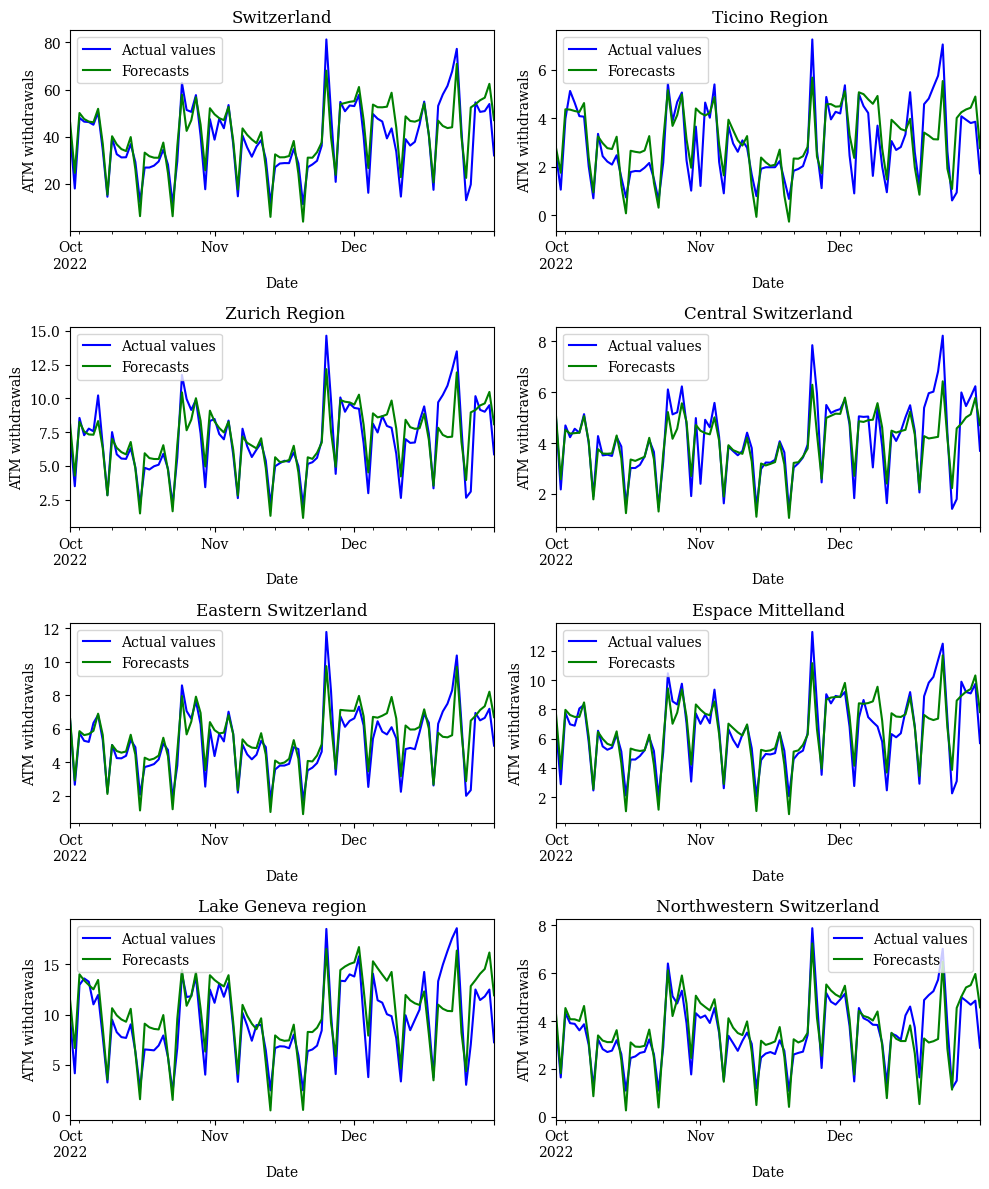

In [44]:
plot_forecasts(harmonic_reg_fcst_test, test_data, specified_ids, mapping, "harmonic_reg")

At the initial stage of the analysis, it is evident that the forecasts generated using local harmonic regression models are more consistent than those produced by the global method. These forecasts do not show significant fluctuations. Compared to the LightGBM method, the forecasts from local models exhibit greater stability and predictability, meaning they capture less of the variability and fluctuations present in the original data. It also appears that sharp increases and decreases in ATM withdrawals are not as accurately reflected in the forecasts as they are in the global model.

## Seasonal naive model

In [45]:
df_train = data[data['ds'] < pd.to_datetime("2022-10-01")].copy()

# Setting up the forecasting model
fcst = StatsForecast(df=df_train,
                     models=[SeasonalNaive(season_length=7)], # weekly seasonality (7 days)
                     freq='D',  # daily data frequency
                     n_jobs=-1) 

# Forecasts on the test and fitted values for the training data
Y_hat_df = fcst.forecast(h=92, fitted=True) # forecasting the next 92 days
Y_fitted_df = fcst.forecast_fitted_values()

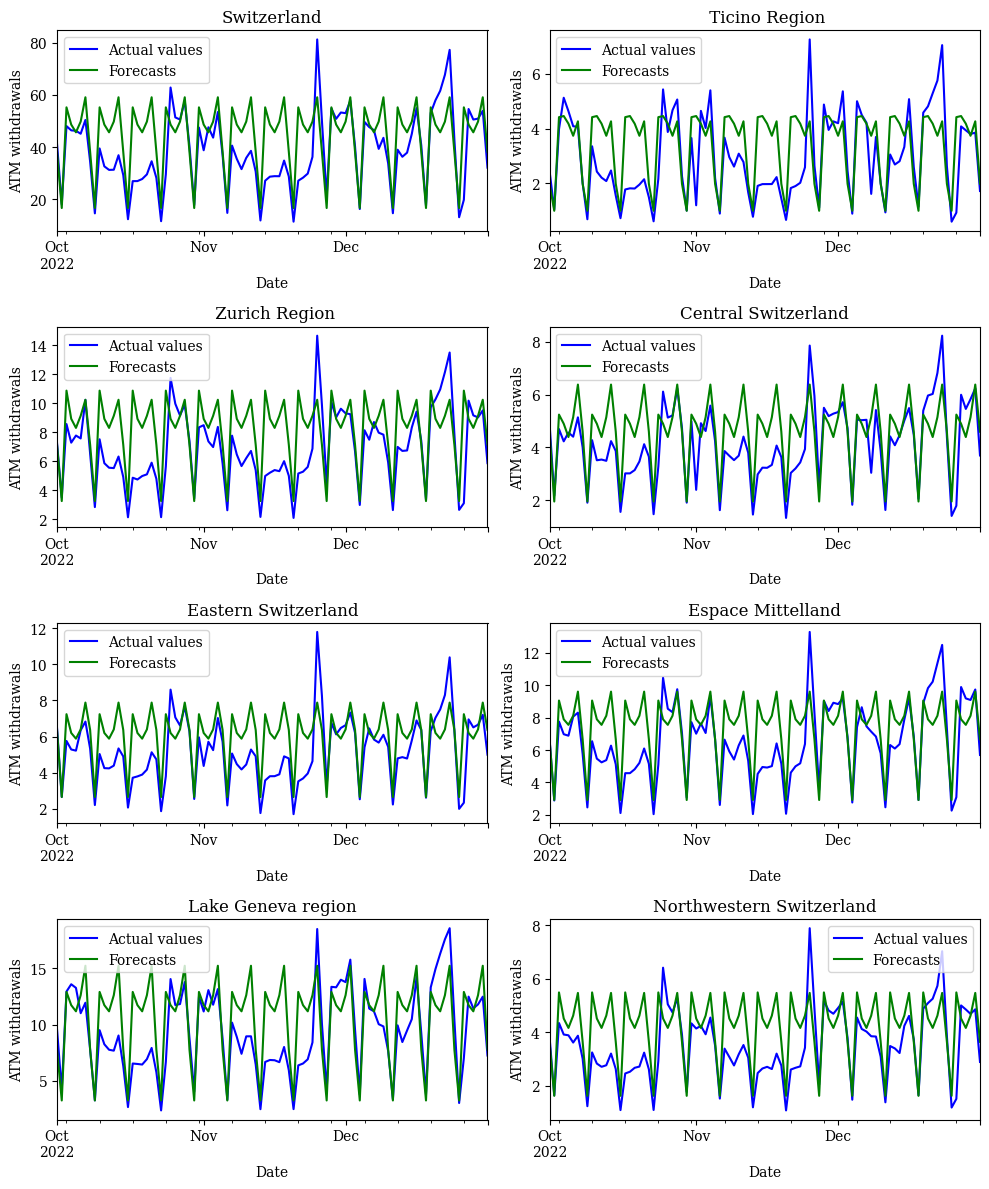

In [46]:
# Plot forecasts
plot_forecasts(Y_hat_df, test_data, specified_ids, mapping, "SeasonalNaive")

The plot of the naive seasonal method, which simply takes the last 7 observations and extends these values onto the test set, shows a very straightforward forecasting approach. Essentially, this method assumes that the most recent data points will continue in the same pattern without any adjustments or predictions for future changes. This results in forecasts that remain constant and do not account for any trends or fluctuations that may occur beyond the observed period.

# Forecasts reconciliation

As all base forecasts have already been generated, these forecasts now need to be properly **reconcilled** to ensure **coherence** across all hierarchical levels, ensuring consistency between lower-level (e.g., region or canton) and higher-level (e.g., country) forecast values. Reconciliation methods used in this project are as follows: **Bottom-Up, Top-Down, MinTrace and Middle-Out**.

## Hierarchical Forecast Reconciliation Setup 

### Summing matrix S

Generate a summing matrix (S) for hierarchical reconciliation. Rows represent unique time series IDs (e.g., levels of a hierarchy) and columns represent "canton" levels in the hierarchy (e.g., subcategories). The matrix indicates how series contribute to aggregated forecasts.

In [47]:
# Extract unique IDs for rows and filter IDs containing 'canton' for columns
unique_ids_rows = data['unique_id'].unique()
unique_ids_cols = [value for value in unique_ids_rows if 'canton' in value]

# Populate the summing matrix with 0/1 indicators
S = pd.DataFrame(0, index=unique_ids_rows, columns=unique_ids_cols)
S.loc[unique_ids_rows, unique_ids_cols] = [[1 if row in col else 0 for col in unique_ids_cols] for row in unique_ids_rows]
S.loc['total', :] = 1

In [48]:
# Result:
# - The matrix S represents the relationships between hierarchical levels.
# - Each cell (row, col) is 1 if the row contributes to the column, otherwise 0.
# - The "total" row ensures reconciliation aligns with the overall totals.
S

region1-cantonGE  region1-cantonVD  region1-cantonVS  \
total                            1                 1                 1   
region1                          1                 1                 1   
region2                          0                 0                 0   
region3                          0                 0                 0   
region4                          0                 0                 0   
region5                          0                 0                 0   
region6                          0                 0                 0   
region7                          0                 0                 0   
region1-cantonGE                 1                 0                 0   
region1-cantonVD                 0                 1                 0   
region1-cantonVS                 0                 0                 1   
region2-cantonBE                 0                 0                 0   
region2-cantonFR                 0                 0                 0   
region2-cantonJU                 0                 0                 0   
region2-cantonNE                 0                 0                 0   
region2-cantonSO                 0                 0                 0   
region3-cantonAG                 0                 0                 0   
region3-cantonBL                 0                 0                 0   
region3-cantonBS                 0                 0                 0   
region4-cantonZH                 0                 0                 0   
region5-cantonAI                 0                 0                 0   
region5-cantonAR                 0                 0                 0   
region5-cantonGL                 0                 0                 0   
region5-cantonGR                 0                 0                 0   
region5-cantonSG                 0                 0                 0   
region5-cantonSH                 0                 0                 0   
region5-cantonTG                 0                 0                 0   
region6-cantonLU                 0                 0                 0   
region6-cantonNW                 0                 0                 0   
region6-cantonOW                 0                 0                 0   
region6-cantonSZ                 0                 0                 0   
region6-cantonUR                 0                 0                 0   
region6-cantonZG                 0                 0                 0   
region7-cantonTI                 0                 0                 0   

                  region2-cantonBE  region2-cantonFR  region2-cantonJU  \
total                            1                 1                 1   
region1                          0                 0                 0   
region2                          1                 1                 1   
region3                          0                 0                 0   
region4                          0                 0                 0   
region5                          0                 0                 0   
region6                          0                 0                 0   
region7                          0                 0                 0   
region1-cantonGE                 0                 0                 0   
region1-cantonVD                 0                 0                 0   
region1-cantonVS                 0                 0                 0   
region2-cantonBE                 1                 0                 0   
region2-cantonFR                 0                 1                 0   
region2-cantonJU                 0                 0                 1   
region2-cantonNE                 0                 0                 0   
region2-cantonSO                 0                 0                 0   
region3-cantonAG                 0                 0                 0   
region3-cantonBL                 0                 0                 0   
region3-cantonBS     

### Tags

In [49]:
# Organize unique hierarchical identifiers (time series) into hierarchy levels ('Country', 'Region', 'Canton') 
categories = ['Country', 'Country/Region', 'Country/Region/Canton']

unique_ids = data['unique_id'].unique()
regions = [unique_id for unique_id in unique_ids if 'region' in unique_id and 'canton' not in unique_id]
regions_cantons = [unique_id for unique_id in unique_ids if 'region' in unique_id and 'canton' in unique_id]
total = ['total']
values = [total] + [regions] + [regions_cantons]

tags = {category: np.array(value, dtype=object) for category, value in zip(categories, values)}

In [50]:
tags

{'Country': array(['total'], dtype=object),
 'Country/Region': array(['region1', 'region2', 'region3', 'region4', 'region5', 'region6',
        'region7'], dtype=object),
 'Country/Region/Canton': array(['region1-cantonGE', 'region1-cantonVD', 'region1-cantonVS',
        'region2-cantonBE', 'region2-cantonFR', 'region2-cantonJU',
        'region2-cantonNE', 'region2-cantonSO', 'region3-cantonAG',
        'region3-cantonBL', 'region3-cantonBS', 'region4-cantonZH',
        'region5-cantonAI', 'region5-cantonAR', 'region5-cantonGL',
        'region5-cantonGR', 'region5-cantonSG', 'region5-cantonSH',
        'region5-cantonTG', 'region6-cantonLU', 'region6-cantonNW',
        'region6-cantonOW', 'region6-cantonSZ', 'region6-cantonUR',
        'region6-cantonZG', 'region7-cantonTI'], dtype=object)}

### Reconciliation methods

In [51]:
# Define a list of reconciliation methods for hierarchical forecasting
reconcilers = [
    MinTrace(method='mint_shrink'),  # Minimum Trace
    BottomUp(),  # Bottom-up reconciliation
    TopDown(method='forecast_proportions'),  # Top-down (with forecasted proportions)
    TopDown(method='average_proportions'),  # Top-down (with average historical proportions)
    TopDown(method='proportion_averages'),  # Top-down (with proportions of historical averages)
    MiddleOut(  # Middle-out (with forecasted proportions and Country/Region level as middle level)
        middle_level='Country/Region', 
        top_down_method='forecast_proportions'
    ),
]

# Initialize the hierarchical reconciliation framework with the defined methods
hrec = HierarchicalReconciliation(reconcilers=reconcilers)

## Perform Hierarchical Forecast Reconciliation

Once the reconciliation methods are defined, apply them to the forecast data to reconcile any discrepancies.

### LightGBM

In [52]:
# Perform hierarchical reconciliation on the LightGBM forecast predictions
# The `reconcile` function reconciles the forecast predictions (`Y_hat_df=test_fcst_lightGBM`) 
# with the training data (`Y_df=train_fcst_lightGBM`), using the aggregation matrix `S` and predefined hierarchy tags `tags`.
lgbm_preds_reconciled_df = hrec.reconcile(Y_hat_df=test_fcst_lightGBM.set_index('unique_id'), Y_df=train_fcst_lightGBM, S=S, tags=tags) #,  level=level)

lgbm_preds_reconciled_df['ds'] = pd.to_datetime(lgbm_preds_reconciled_df['ds'])
lgbm_preds_reconciled_df.head(2)

ds   lightGBM  lightGBM/MinTrace_method-mint_shrink  \
unique_id                                                               
total     2022-10-01  41.069206                             41.211650   
total     2022-10-02  17.441324                             17.346584   

           lightGBM/BottomUp  lightGBM/TopDown_method-forecast_proportions  \
unique_id                                                                    
total              40.569195                                     41.069206   
total              16.228672                                     17.441324   

           lightGBM/TopDown_method-average_proportions  \
unique_id                                                
total                                        41.069205   
total                                        17.441324   

           lightGBM/TopDown_method-proportion_averages  \
unique_id                                                
total                                        41.069206   
total                                        17.441324   

           lightGBM/MiddleOut_middle_level-Country/Region_top_down_method-forecast_proportions  
unique_id                                                                                       
total                                              41.312870                                    
total                                              16.882053

### Harmonic regression

In [53]:
harmonic_reg_preds_reconciled_df = hrec.reconcile(Y_hat_df=harmonic_reg_fcst_test.set_index('unique_id'), Y_df=harmonic_reg_fcst_train, S=S, tags=tags) #,  level=level)
harmonic_reg_preds_reconciled_df.head(2)

ds  harmonic_reg  harmonic_reg/MinTrace_method-mint_shrink  \
unique_id                                                                      
total     2022-10-01     45.859417                                 45.842382   
total     2022-10-02     24.701713                                 23.975051   

           harmonic_reg/BottomUp  \
unique_id                          
total                  45.517246   
total                  24.050562   

           harmonic_reg/TopDown_method-forecast_proportions  \
unique_id                                                     
total                                             45.859417   
total                                             24.701714   

           harmonic_reg/TopDown_method-average_proportions  \
unique_id                                                    
total                                            45.859416   
total                                            24.701713   

           harmonic_reg/TopDown_method-proportion_averages  \
unique_id                                                    
total                                            45.859419   
total                                            24.701715   

           harmonic_reg/MiddleOut_middle_level-Country/Region_top_down_method-forecast_proportions  
unique_id                                                                                           
total                                              45.628693                                        
total                                              23.951174

### Seasonal naive method

In [54]:
seasonal_naive_preds_reconciled_df = hrec.reconcile(Y_hat_df=Y_hat_df, Y_df=Y_fitted_df, S=S, tags=tags)
seasonal_naive_preds_reconciled_df.head(2)

ds  SeasonalNaive  \
unique_id                             
total     2022-10-01      38.145805   
total     2022-10-02      16.639614   

           SeasonalNaive/MinTrace_method-mint_shrink  SeasonalNaive/BottomUp  \
unique_id                                                                      
total                                      38.145806               38.145802   
total                                      16.639613               16.639612   

           SeasonalNaive/TopDown_method-forecast_proportions  \
unique_id                                                      
total                                              38.145805   
total                                              16.639614   

           SeasonalNaive/TopDown_method-average_proportions  \
unique_id                                                     
total                                             38.145804   
total                                             16.639614   

           SeasonalNaive/TopDown_method-proportion_averages  \
unique_id                                                     
total                                             38.145807   
total                                             16.639615   

           SeasonalNaive/MiddleOut_middle_level-Country/Region_top_down_method-forecast_proportions  
unique_id                                                                                            
total                                              38.145805                                         
total                                              16.639614

# Rolling average forecast error

The accuracy of the models and their comparison were conducted by analyzing **the average forecast error as a function of a variable forecast horizon** based on all forecasts across the hierarchy levels (from country to cantons). This technique allows tracking the variability of forecast accuracy at different time points and understanding how the model performs in forecasting depending on the length of the forecast horizon. This helps to better understand the limitations of the models and their fit to the complexity of the analyzed time series. 

The quality of the obtained models was assessed using **Root Mean Square Error (RMSE)** metric.

In [55]:
def remap_columns(reconciled_df, model_name):
    """
    Remaps column names in a DataFrame to more readable names for specified reconciliation methods.

    Parameters:
        reconciled_df (pd.DataFrame): DataFrame containing reconciled forecast data.
        model_name (str): Name of the base forecast model.

    Returns:
        pd.DataFrame: DataFrame with remapped column names.
    """
    original_columns = [
        'ds', model_name, 
        f"{model_name}/MinTrace_method-mint_shrink",
        f"{model_name}/BottomUp", 
        f"{model_name}/TopDown_method-forecast_proportions",
        f"{model_name}/TopDown_method-average_proportions",
        f"{model_name}/TopDown_method-proportion_averages",
        f"{model_name}/MiddleOut_middle_level-Country/Region_top_down_method-forecast_proportions"
    ]
    
    new_columns = [
        'ds', 'base', 'MinTrace', 'BottomUp', 
        'TopDown-fp', 'TopDown-ap', 'TopDown-pa', 'MiddleOut'
    ]
    
    return reconciled_df[original_columns].rename(columns=dict(zip(original_columns, new_columns)))

In [56]:
def calculate_rmse(reconciled_df, model_name, actual_test_df):
    """
    Calculates rolling RMSE for reconciled forecasts against actual test data.

    Parameters:
        reconciled_df (pd.DataFrame): DataFrame with reconciled forecast data.
        model_name (str): Name of the base forecast model.
        actual_test_df (pd.DataFrame): DataFrame with actual test values.

    Returns:
        pd.DataFrame: DataFrame with rolling RMSE values for each method.
    """
    # Merge with actual values
    reconciled_df = pd.merge(
        reconciled_df, 
        actual_test_df[['ds', 'unique_id', 'y']], 
        on=['ds', 'unique_id'], 
        how='left'
    ).rename(columns={'y': 'actual_value'})

    # Calculate RMSE for each date and method
    methods = ['base', 'MinTrace', 'BottomUp', 'TopDown-fp', 'TopDown-ap', 'TopDown-pa', 'MiddleOut']
    rmse_results = []
    for date in reconciled_df['ds']:
        subset = reconciled_df[reconciled_df['ds'] <= date]
        actual = subset['actual_value']
        for method in methods:
            rmse = sqrt(mean_squared_error(actual, subset[method]))
            rmse_results.append({'date': date, 'method': method, 'RMSE': rmse})

    # Map method names for readability
    method_mapping = {
        'BottomUp': 'Bottom-up',
        'MiddleOut': 'Middle-out',
        'MinTrace': 'Minimum Trace',
        'TopDown-ap': 'Top-down (historical average proportions)',
        'TopDown-fp': 'Top-down (forecasted proportions)',
        'TopDown-pa': 'Top-down (average historical proportions)',
        'base': 'Base Forecasts',
    }
    rmse_df = pd.DataFrame(rmse_results)
    rmse_df['method'] = rmse_df['method'].map(method_mapping)

    return rmse_df

## Global model - LightGBM

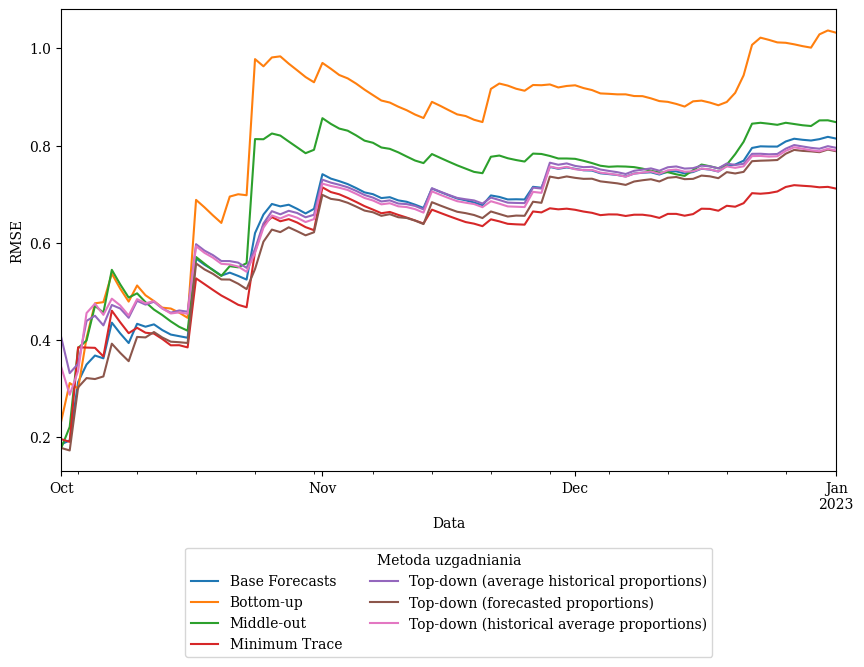

In [57]:
# Rename column names
lgbm_preds_reconciled_df = remap_columns(lgbm_preds_reconciled_df, 'lightGBM')

# Calculate rolling RMSE
rmse_df = calculate_rmse(lgbm_preds_reconciled_df, 'lightGBM', test_data)

df_agg = rmse_df.groupby(['date', 'method']).mean().reset_index()

rmse_lightgbm = df_agg.pivot(index='date', columns='method', values='RMSE')

# Plot rolling RMSE
rmse_lightgbm.plot(linestyle='-', figsize=(10, 6))
plt.xlabel('Data')
plt.ylabel('RMSE')
plt.legend(title='Metoda uzgadniania', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2, fontsize='medium')
plt.show()

The method that stands out in terms of forecast accuracy is the **Minimum Trace** reconciliation method, which maintains the **lowest RMSE values**, especially for longer forecasting horizons. This method also exhibits the least variability and deviations in the average RMSE. Top-down methods generate comparable results, with the method based on forecasted proportions appearing to be the most effective among them.

On the other hand, the **bottom-up** and **middle-out** methods tend to produce the **highest and most variable RMSE values**, especially in the later forecasting periods. While their errors are similar to other methods in the early time points, these values increase rapidly as the forecasting horizon expands, and the plots remain at a higher level compared to the other reconciliation methods. 

Furthermore, the **middle-out** and **bottom-up** methods seem to be **more sensitive to noise and fluctuations** in the data. When all methods show an increase, the plots for the middle-out and bottom-up techniques exhibit the most dynamic growth. The potential causes for this behavior could be related to the specific characteristics of these methods. Both rely on aggregating forecasts from lower levels of the hierarchy, which may be more vulnerable to irregular changes and noise, ultimately leading to a decrease in forecast accuracy.

## Local model - Harmonic Regression

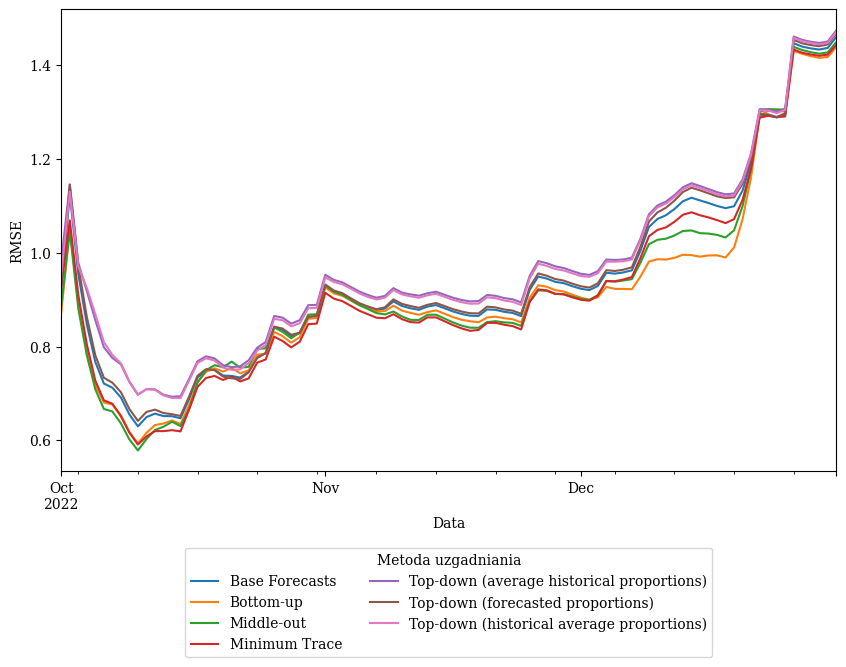

In [58]:
# Rename column names
harmonic_reg_preds_reconciled_df = remap_columns(harmonic_reg_preds_reconciled_df, 'harmonic_reg')

# Calculate rolling RMSE
rmse_df = calculate_rmse(harmonic_reg_preds_reconciled_df, 'harmonic_reg', test_data)

df_agg = rmse_df.groupby(['date', 'method']).mean().reset_index()

rmse_harmonic_reg = df_agg.pivot(index='date', columns='method', values='RMSE')

# Plot rolling RMSE
rmse_harmonic_reg.plot(linestyle='-', figsize=(10, 6))
plt.xlabel('Data')
plt.ylabel('RMSE')
plt.legend(title='Metoda uzgadniania', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2, fontsize='medium')
plt.show()

An analysis of the charts for all reconciliation methods reveals that they exhibit similar patterns and behaviors, without significant differences among them, unlike the global model where such distinctions were more pronounced. Additionally, the RMSE values for the base forecasts remain relatively consistent, suggesting that **applying reconciliation methods did not substantially improve the forecast accuracy** achieved using harmonic regression models. This implies that the choice of reconciliation method in local models has a limited impact on the accuracy of the forecasts.

However, there are some minor differences. The **highest accuracy**, measured by RMSE, is achieved by the **Minimum Trace**, **middle-out**, and **bottom-up** methods. In contrast, top-down methods produce slightly higher error values. While Minimum Trace demonstrates strong performance across both the global and local models, the other reconciliation techniques show an inverse trend compared to earlier observations. Top-down methods, which used to achieve the best results, are now giving way to middle-out and bottom-up methods, which used to be the least accurate in case of global model.

It can be concluded that **disaggregating forecasts from higher levels of the hierarchy to lower levels results in a loss of accuracy**. A better approach seems to involve using reconciliation techniques based on time series forecasts from the lower levels of the hierarchical structure. The RMSE metric initially hovers around 1 for the first points of forecasting horizon, followed by a significant decrease. However, after mid-October, the **average RMSE begins to rise** again, with a notable **spike in December**. This sharp increase after mid-December may be linked to the challenges faced by local methods in forecasting the higher levels of ATM withdrawals during the Christmas season.

## Seasonal naive model

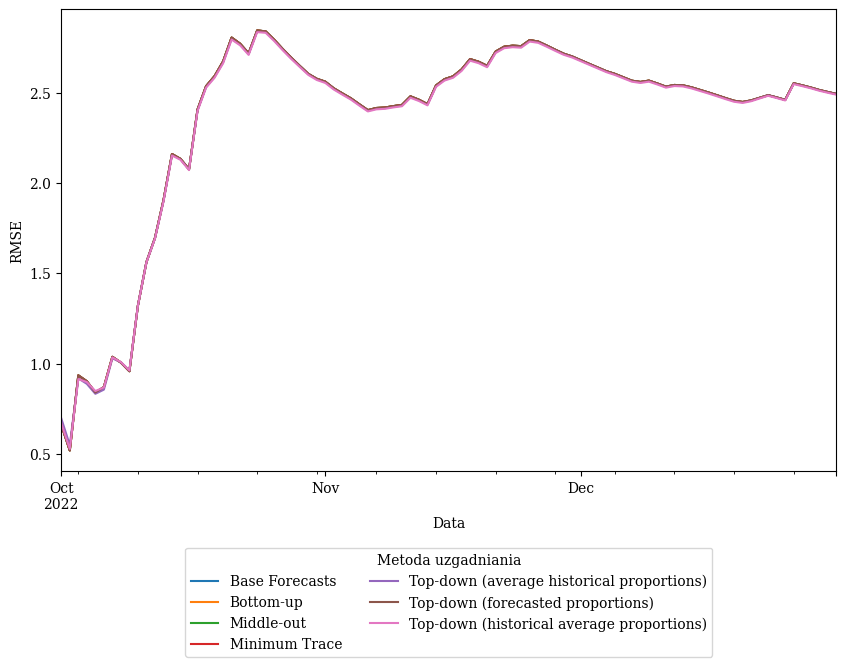

In [59]:
# Rename column names
seasonal_naive_preds_reconciled_df = remap_columns(seasonal_naive_preds_reconciled_df, 'SeasonalNaive')

# Calculate rolling RMSE
rmse_df = calculate_rmse(seasonal_naive_preds_reconciled_df, 'SeasonalNaive', test_data)

df_agg = rmse_df.groupby(['date', 'method']).mean().reset_index()

rmse_naive = df_agg.pivot(index='date', columns='method', values='RMSE')

# Plot rolling RMSE
rmse_naive.plot(linestyle='-', figsize=(10, 6))
plt.xlabel('Data')
plt.ylabel('RMSE')
plt.legend(title='Metoda uzgadniania', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2, fontsize='medium')
plt.show()

*Note: Due to the specifics of the seasonal naive method, where forecasts are equal to the real values observed in the past, this inherently ensures coherence across observations.* 

For the seasonal naive method, the RMSE **rises rapidly** and then stabilizes at a significantly higher level compared to the previous global and local models. This suggests that the seasonal naive method provides **weaker predictions**, indicating a **less accurate model** in comparison to the other reconciliation techniques.

# MAPE

The average MAPE values for each hierarchical forecasting reconciliation method were compared across the different levels of the hierarchy. This allows for the possibility of identifying patterns regarding which model and reconciliation methods performs better at different hierarchy levels or levels of granularity.

In [60]:
# Define helper function to compute MAPE
def mape(actual, forecast):
    """Calculate Mean Absolute Percentage Error (MAPE)."""
    return np.mean(np.abs((actual - forecast) / actual)) * 100

def calculate_forecast_metrics(df, test_data, forecast_types):
    """
    Calculates forecast accuracy metric (MAPE) for forecast at different hierarchical levels.

    Parameters:
        df (pd.DataFrame): DataFrame containing forecast data.
        test_data (pd.DataFrame): DataFrame containing actual test values ('y') along with 'ds' (dates) and 'unique_id'.
        forecast_types (list): List of column names representing different forecast types to evaluate.

    Returns:
        pd.DataFrame: Pivot table containing MAPE values for each forecast type across hierarchical levels.
    """
    # Add a column for the hierarchy level based on index patterns
    df.loc[df.index == 'total', 'level'] = 'total'
    df.loc[df.index.str.startswith('region'), 'level'] = 'region'
    df.loc[df.index.str.contains('canton'), 'level'] = 'canton'

    # Merge with actual values from test data
    df = pd.merge(df, test_data[['ds', 'unique_id', 'y']], on=['ds', 'unique_id'], how='right')

    # Initialize DataFrame to store MAPE results
    mape_df = pd.DataFrame(columns=['Forecast Type', 'Level', 'MAPE'])

    # Compute MAPE for each forecast type and hierarchical level
    for forecast_type in forecast_types:
        for level in df['level'].unique():
            subset = df[df['level'] == level]
            mape_value = mape(subset['y'], subset[forecast_type])
            mape_df = mape_df._append({'Forecast Type': forecast_type, 'Level': level, 'MAPE': mape_value}, ignore_index=True)

    # Compute average MAPE across all levels for each forecast type
    mean_mape = df.groupby('level').apply(lambda x: x[forecast_types].apply(lambda y: mape(x['y'], y)), include_groups=False).mean(axis=0)
    
    # Add mean MAPE values to the DataFrame
    for forecast_type, value in mean_mape.items():
        mape_df = mape_df._append({'Forecast Type': forecast_type, 'Level': 'Mean', 'MAPE': value}, ignore_index=True)

    # Transform results into a pivot table for better readability
    mape_pivot = mape_df.pivot(index='Forecast Type', columns='Level', values='MAPE')

    return mape_pivot

## Global model - LightGBM

In [61]:
forecast_types = ['base', 'MinTrace', 'BottomUp', 'TopDown-fp', 'TopDown-ap', 'TopDown-pa', 'MiddleOut']
lightgbm_mape_pivot = calculate_forecast_metrics(lgbm_preds_reconciled_df, test_data, forecast_types)

print("MAPE:")
print(round(lightgbm_mape_pivot[["canton", "region", "total", "Mean"]], 4))

MAPE:
Level           canton   region   total     Mean
Forecast Type                                   
BottomUp       30.2259  13.8939  9.8689  17.9962
MiddleOut      28.3811  12.8070  8.2322  16.4734
MinTrace       27.2164  10.9477  6.8671  15.0104
TopDown-ap     18.7460  12.9028  7.8252  13.1580
TopDown-fp     27.2080  11.9470  7.8252  15.6601
TopDown-pa     18.5069  13.5677  7.8252  13.2999
base           30.2259  12.8070  7.8252  16.9527


The MAPE values confirm the previous findings. The **errors obtained for forecasts at lower hierarchical levels are significantly higher than those at higher levels**. The same trend can be observed across all reconciliation methods as well as base forecasts. Furthermore, the analysis showed that forecasting methods that rely more on data from lower hierarchical levels, such as **bottom-up and middle-out, tended to generate less accurate forecasts compared to top-down** methods.

The conclusion that can be drawn from the analysis is that forecast errors, measured by the MAPE metric, differ significantly depending on the hierarchical level of the time series. **Errors are much higher for time series with lower levels of aggregation, suggesting that these data are less stable or more prone to disruptions, and the forecasting model performs worse at predicting the original values. Higher data aggregation reduces the impact of outliers, leading to smoother and more predictable patterns in the data, which in turn improves forecast quality.** The Minimum Trace method proved to be the best in terms of average MAPE across all hierarchical levels. However, while the MAPE for this method was the lowest for series corresponding to Swiss regions and the entire country, two of the top-down methods achieved better results for data regarding cantons.

## Local model - Harmonic regression

In [62]:
forecast_types = ['base', 'MinTrace', 'BottomUp', 'TopDown-fp', 'TopDown-ap', 'TopDown-pa', 'MiddleOut']
harmonic_reg_mape_pivot = calculate_forecast_metrics(harmonic_reg_preds_reconciled_df, test_data, forecast_types)

print("MAPE:")
print(round(harmonic_reg_mape_pivot[["canton", "region", "total", "Mean"]], 4))

MAPE:
Level           canton   region    total     Mean
Forecast Type                                    
BottomUp       21.8727  19.7785  16.6433  19.4315
MiddleOut      21.8526  19.8995  16.9735  19.5752
MinTrace       22.0822  20.0954  17.2076  19.7951
TopDown-ap     29.0841  22.7283  18.0446  23.2857
TopDown-fp     22.4896  20.8901  18.0446  20.4747
TopDown-pa     28.5485  23.1826  18.0446  23.2586
base           21.8727  19.8995  18.0446  19.9389


The MAPE errors for base forecasts generated using local harmonic regression models are **highest at the lowest hierarchical level and lowest at the highest level**. The same pattern was observed for the global model. 

When it comes to reconciliation methods, the **MAPE values for the different reconcilaition methods within the same hierarchical levels do not show significant differences**. The worst performance was observed for top-down methods, particularly those using historical average ratios or historical ratio averages for data disaggregation to lower levels. The **best results were achieved by the middle-out, bottom-up, and Minimum Trace methods.**

# Final models comparison

Below figure compares the effectiveness of global and local models in the context of hierarchical forecasting, based on RMSE values for different forecast horizons. For each approach, the most effective reconciliation methods were selected based on the average RMSE, calculated using forecast errors on the test set. The goal is not only to compare the quality of both approaches but also to analyze their sensitivity to increasing forecast horizons and the rate at which predictive accuracy is getting worse. For a more comprehensive comparison, results from the seasonal naive method were also included to verify whether advanced methods truly enhance forecasting performance.

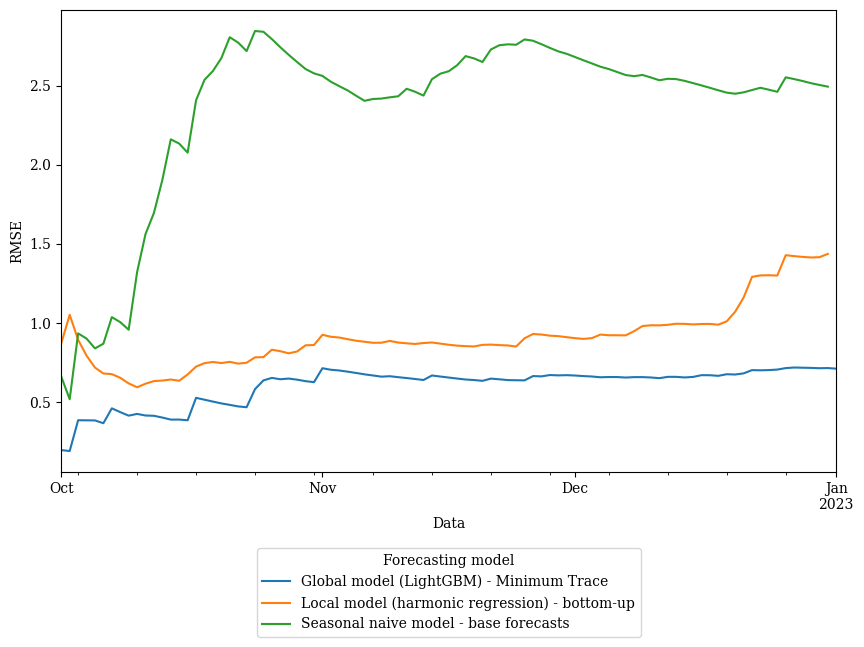

In [63]:
rmse_merged = pd.DataFrame({
    'Global model (LightGBM) - Minimum Trace': rmse_lightgbm["Minimum Trace"],
    'Local model (harmonic regression) - bottom-up': rmse_harmonic_reg["Bottom-up"],
    'Seasonal naive model - base forecasts': rmse_naive["Base Forecasts"]
})

rmse_merged.plot(linestyle='-', figsize=(10, 6))
plt.xlabel('Data')
plt.ylabel('RMSE')
plt.legend(title='Forecasting model', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=1, fontsize='medium')
plt.show()

Both the **global and local models outperform the seasonal naive method**, significantly improving the accuracy of ATM cash withdrawal forecasts. Furthermore, a clear **advantage of the global model over the local model** can be observed, as its curve on the graph lies consistently below the curve for the local method. 

While the local model's RMSE increases steadily with the forecast horizon, particularly in December, the **global model's RMSE stabilizes around November and remains relatively consistent**. The variations are less pronounced, and RMSE remains relatively consistent. This indicates that the **global model is less sensitive to longer forecast horizons**, making it more reliable for long-term predictions. This characteristic is particularly advantageous for accurately predicting future events, especially from a long-term perspective.

Below are presented the average MAPE values for both the global and local models, along with various reconciliation methods.

In [64]:
# Combine MAPE for both local and global models
lightgbm_mean_mape = lightgbm_mape_pivot['Mean']
harmonic_reg_mean_mape = harmonic_reg_mape_pivot['Mean']
print(pd.DataFrame({'Global model (LightGBM)': lightgbm_mean_mape, 'Local model (Harmonic regression)': harmonic_reg_mean_mape}))

               Global model (LightGBM)  Local model (Harmonic regression)
Forecast Type                                                            
BottomUp                     17.996213                          19.431488
MiddleOut                    16.473447                          19.575216
MinTrace                     15.010401                          19.795070
TopDown-ap                   13.158002                          23.285665
TopDown-fp                   15.660063                          20.474736
TopDown-pa                   13.299922                          23.258561
base                         16.952695                          19.938948


It can again be observed that the **best results were achieved with the global approach**, where the forecasting model was LightGBM. Furthermore, the **MAPE value was reduced (compared to the base forecasts obtained directly from the LightGBM model) by applying appropriate reconciliation methods**, such as Minimum Trace and top-down methods. Hierarchical forecasting and reconciling predictions proved to be justified in this case, as it brought measurable benefits. **Local models are not as effective as global models, and applying reconciliation methods does not yield such beneficial results for them.** While some methods generated better results, the reduction in errors was minimal, and the MAPE metric obtained for the base forecasts did not significantly improve.

# Conclusions

This project compared local and global hierarchical forecasting models. The global model used the LightGBM machine learning algorithm, while the local model employed harmonic regression incorporating Fourier components and ARMA errors. The data analyzed involved ATM withdrawals with a hierarchical structure spanning country, regions, and cantons.
Both models utilized reconciliation methods such as bottom-up, middle-out, top-down, and Minimum Trace to generate coherent forecasts. This allowed for consistent forecasts across all levels of the hierarchy and enabled the assessment of the effectiveness of both local and global models in hierarchical forecasting.

**1. Best performing approach**

The best forecasting results for ATM withdrawals were achieved using the global model with LightGBM, particularly in combination with the Minimum Trace reconciliation technique.
Both the global and local models significantly outperformed the naive method, suggesting that both approaches are justified and effective.

**2. Performance over longer forecast horizons**

The global model performed better for longer forecast horizons, showing less sensitivity to the extension of the forecast period.
On the other hand, the local model struggled with irregularities in the data and higher variability, particularly visible in the December period, leading to a significant increase in forecast errors.

**3. Reconciliation methods in local vs global models**

Analysis of different reconciliation methods in the local model showed no significant differences or improvements in forecast accuracy.
In the global model, however, there were noticeable discrepancies between methods, with some methods yielding worse results than the base forecasts, while others led to improvements.
The findings suggest that while reconciliation methods are not always guaranteed to improve accuracy, their application can lead to significant benefits. Further research is recommended to compare the effectiveness of different methods and evaluate their impact on forecast accuracy.

**4. Variability across different hierarchy levels**

Base forecast errors were consistently larger at lower levels of the hierarchy, which are characterized by higher variability, more frequent deviations, and less stable data. This leads to reduced forecast accuracy.
Higher levels of the hierarchy, with more aggregated data, help reduce potential noise and stabilize patterns, thus improving forecast quality.
Notably, base forecast errors at the lowest levels of the hierarchy were lower for local models. This is due to local models being built for each time series separately, allowing them to better adapt to the unique characteristics of each series.

**5. Use of global models for high noise data**

In cases where time series exhibit higher levels of noise at lower hierarchy levels, the global model can provide substantial benefits. Reconciliation methods like Minimum Trace or top-down help mitigate noise by using forecasts from higher levels, which are typically more stable.
Conversely, for time series that exhibit higher predictability, stability, and lower variability, local models might be more effective. This is because local models are better suited to capture the unique characteristics of each time series without over-generalizing based on higher-level patterns.

**6. Further research directions**

Investigating the performance of both local and global models should continue. Specifically, future research could explore how the choice of forecasting model influences the effectiveness of local and global methods. 
Comparing other forecasting models, such as those beyond harmonic regression and LightGBM, could contribute to more general and comprehensive conclusions about the effectiveness of different approaches.
Additionally, testing both global and local models on datasets with different characteristics, behaviors, and properties would offer a deeper understanding of how both models perform based on the specific nature of the data. This could have important implications for their practical application in various contexts and scenarios.

<div style="font-size: 30px; font-weight: bold; line-height: 1.2; margin-top: 20px; margin-bottom: 20px;">References</div>

https://otexts.com/fpp3/hierarchical.html

https://nixtlaverse.nixtla.io/hierarchicalforecast/index.html